# Introducción a la Ciencia de Datos: Tarea 2

Este notebook contiene el código de base para realizar la Tarea 2 del curso. Puede copiarlo en su propio repositorio y trabajar sobre el mismo.
Las **instrucciones para ejecutar el notebook** están en la [página inicial del repositorio](https://gitlab.fing.edu.uy/maestria-cdaa/intro-cd/).

**Se espera que no sea necesario revisar el código para corregir la tarea**, ya que todos los resultados y análisis relevantes deberían estar en el **informe en formato PDF**.


## Cargar bibliotecas (dependencias)
Recuerde instalar los requerimientos (`requirements.txt`) en el mismo entorno donde está ejecutando este notebook (ver [README](https://gitlab.fing.edu.uy/maestria-cdaa/intro-cd/)). Para la entrega 2 hay nuevas dependencias, por lo que es importante correr la siguiente celda.

In [88]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [89]:
!pip install -r '/content/drive/MyDrive/MCDAA - 1er sem/IntroCD/Tarea2_grupo12/requirements.txt'

ERROR: Could not open requirements file: [Errno 2] No such file or directory: '/content/drive/MyDrive/MCDAA - 1er sem/IntroCD/Tarea2_grupo12/requirements.txt'


In [90]:
import re
import os

from time import time
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
import nltk
import matplotlib.patches as mpatches


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import PCA
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

## Lectura de Datos

In [91]:
### DataFrame con todos los discursos:
#df_speeches = pd.read_csv('/content/drive/MyDrive/MCDAA - 1er sem/IntroCD/Tarea2_grupo12/us_2020_election_speeches.csv')

df_speeches = pd.read_csv('/content/drive/MyDrive/IntroCD/tareas/Tarea1_grupo12/us_2020_election_speeches.csv')

df_speeches

,speaker,title,text,date,location,type
0,David Perdue,Georgia Sen. David Perdue Speech Transcript at...,David Perdue: (00:01)\nHow great is it to be b...,"Oct 16, 2020","Macon, Georgia",Campaign Speech
1,Joe Biden,"Joe Biden Southfield, MI Speech on Health Care...","Joe Biden: (00:00)\nHello, Michigan. Hi, how a...","Oct 16, 2020","Southfield ,Michigan",Campaign Speech
2,Donald Trump,Donald Trump Speech Transcript ‘Protecting Ame...,President Trump: (00:30)\nThank you. What a ni...,"Oct 16, 2020","Fort Myers, Florida",Campaign Speech
3,Joe Biden,Joe Biden ABC Town Hall Transcript October 15,"George Stephanopoulos: (00:41)\nHey, and welco...","Oct 15, 2020",ABC,Town Hall
4,Donald Trump,Donald Trump NBC Town Hall Transcript October 15,Savannah Guthrie: (03:50)\nIt’s nothing but no...,"Oct 15, 2020",NBC,Town Hall
...,...,...,...,...,...,...
264,Bernie Sanders,Bernie Sanders Speech Transcript: Sanders Spea...,Bernie Sanders: (00:00)\nJust want to take thi...,"Feb 6, 2020",Iowa,Campaign Speech
265,Democratic Candidates,Transcript: Speeches at the Iowa Caucuses – Be...,Bernie Sanders: (00:08)\nThank you. Thank you....,"Feb 4, 2020",Iowa,Campaign Speech
266,Donald Trump,Donal Trump Iowa Rally Transcript: Trump Holds...,Donald Trump: (00:24)\nI worked so hard for th...,"Jan 30, 2020","Des Moines, Iowa",Campaign Speech
267,Donald Trump,Donald Trump New Jersey Rally Speech Transcrip...,Donald Trump: (01:22)\nThank you. Thank you. I...,"Jan 28, 2020","Wildwood, New Jersey",Campaign Speech


##Conjunto de datos a usar

In [92]:
### DataFrame con todos los párrafos:

import pandas as pd
import re

# Crear identificador de discurso si no existe
df_speeches_ = df_speeches.reset_index().rename(columns={'index': 'speech_id'})

# Lista para guardar resultados
rows = []

# Regex mejorado para detectar oradores
pattern = re.compile(r'([A-Za-z0-9 ]+): \(\d{2}:\d{2}\)')

for _, row in df_speeches_.iterrows():
    text = row['text']
    matches = list(pattern.finditer(text))

    for i, match in enumerate(matches):
        speaker = match.group(1)
        start = match.end()
        end = matches[i + 1].start() if i + 1 < len(matches) else len(text)
        paragraph = text[start:end].strip()
        rows.append({
            'paragraph_speaker': speaker,
            'paragraph': paragraph,
            'speech_id': row['speech_id'],
            **{k: row[k] for k in df_speeches.columns if k not in ['text', 'speech_id']}
        })

# Crear nuevo DataFrame
df_paragraphs = pd.DataFrame(rows)
df_paragraphs

,paragraph_speaker,paragraph,speech_id,speaker,title,date,location,type
0,David Perdue,"How great is it to be back in Macon, Georgia w...",0,David Perdue,Georgia Sen. David Perdue Speech Transcript at...,"Oct 16, 2020","Macon, Georgia",Campaign Speech
1,David Perdue,That did not happen by accident. Brian Kemp is...,0,David Perdue,Georgia Sen. David Perdue Speech Transcript at...,"Oct 16, 2020","Macon, Georgia",Campaign Speech
2,David Perdue,"Now guys, I’m just a dumb business guy for rig...",0,David Perdue,Georgia Sen. David Perdue Speech Transcript at...,"Oct 16, 2020","Macon, Georgia",Campaign Speech
3,David Perdue,"Seven and a half million new jobs, highest mid...",0,David Perdue,Georgia Sen. David Perdue Speech Transcript at...,"Oct 16, 2020","Macon, Georgia",Campaign Speech
4,David Perdue,"But it took Donald Trump, not the bureaucrats ...",0,David Perdue,Georgia Sen. David Perdue Speech Transcript at...,"Oct 16, 2020","Macon, Georgia",Campaign Speech
...,...,...,...,...,...,...,...,...
17587,Amy Klobuchar,… people trying to help their parents.,268,Democratic Candidates,January Iowa Democratic Debate Transcript,"Jan 15, 2020","Des Moines, Iowa",Debate
17588,Moderator 2,Senator Warren?\nE.,268,Democratic Candidates,January Iowa Democratic Debate Transcript,"Jan 15, 2020","Des Moines, Iowa",Debate
17589,Warren,So we need to start with what’s happening in A...,268,Democratic Candidates,January Iowa Democratic Debate Transcript,"Jan 15, 2020","Des Moines, Iowa",Debate
17590,Warren,My approach to this is we’ve got to get as muc...,268,Democratic Candidates,January Iowa Democratic Debate Transcript,"Jan 15, 2020","Des Moines, Iowa",Debate


In [93]:
### Unificar las variantes de paragraph_speaker

import pandas as pd
import numpy as np

def unify_speaker(speaker):
    # Quitar espacios al inicio y fin para normalizar
    speaker_clean = speaker.strip()

    trump_variants = {
        'Trump', 'Donald Trump', 'President Donald Trump', 'President Trump', ' Trump'
    }
    biden_variants = {
        'Joe Biden', 'Joe Biden ', 'VIce President Biden', 'Vice President Joe Biden'
    }
    harris_variants = {
        'Kamala Harris', 'Kamala Harris ', 'Senator Harris', 'Senator Kamala Harris'
    }
    pence_variants = {
        'Mike Pence', 'Vice President Mike Pence', 'Vice President Mike Pence '
    }
    sanders_variants = {
        'Bernie Sanders', 'Sanders'
    }

    if speaker_clean in trump_variants:
        return 'Donald Trump'
    elif speaker_clean in biden_variants:
        return 'Joe Biden'
    elif speaker_clean in harris_variants:
        return 'Kamala Harris'
    elif speaker_clean in pence_variants:
        return 'Mike Pence'
    elif speaker_clean in sanders_variants:
        return 'Bernie Sanders'
    else:
        return speaker_clean  # Otros oradores se mantienen igual

df_paragraphs['paragraph_speaker'] = df_paragraphs['paragraph_speaker'].apply(unify_speaker)


In [94]:
### DataFrame con todos los discursos por cada orador:

group_cols = [col for col in df_paragraphs.columns if col not in ['paragraph']]

df_grouped = df_paragraphs.groupby(group_cols).agg({
    'paragraph': ' '.join
}).reset_index()

df_grouped = df_grouped.rename(columns={'paragraph': 'text'})

# Ordenar por speech_id
df_grouped = df_grouped.sort_values('speech_id').reset_index(drop=True)

df_grouped


,paragraph_speaker,speech_id,speaker,title,date,location,type,text
0,David Perdue,0,David Perdue,Georgia Sen. David Perdue Speech Transcript at...,"Oct 16, 2020","Macon, Georgia",Campaign Speech,"How great is it to be back in Macon, Georgia w..."
1,Joe Biden,1,Joe Biden,"Joe Biden Southfield, MI Speech on Health Care...","Oct 16, 2020","Southfield ,Michigan",Campaign Speech,"Hello, Michigan. Hi, how are you? What’s your ..."
2,Ron DeSantis,2,Donald Trump,Donald Trump Speech Transcript ‘Protecting Ame...,"Oct 16, 2020","Fort Myers, Florida",Campaign Speech,[inaudible 00:42:08]. Very soon.
3,Seema,2,Donald Trump,Donald Trump Speech Transcript ‘Protecting Ame...,"Oct 16, 2020","Fort Myers, Florida",Campaign Speech,[inaudible 00:01:53].
4,Speaker 2,2,Donald Trump,Donald Trump Speech Transcript ‘Protecting Ame...,"Oct 16, 2020","Fort Myers, Florida",Campaign Speech,"Welcome to town, Mr. President."
...,...,...,...,...,...,...,...,...
1314,Warren,268,Democratic Candidates,January Iowa Democratic Debate Transcript,"Jan 15, 2020","Des Moines, Iowa",Debate,I believe the principal job of the Commander i...
1315,Wolf Blitzer,268,Democratic Candidates,January Iowa Democratic Debate Transcript,"Jan 15, 2020","Des Moines, Iowa",Debate,"All right, so let’s begin right now. Just this..."
1316,Amy Klobuchar,268,Democratic Candidates,January Iowa Democratic Debate Transcript,"Jan 15, 2020","Des Moines, Iowa",Debate,"Thank you Wolf, and I’ve been very clear that ..."
1317,Tom Steyer,268,Democratic Candidates,January Iowa Democratic Debate Transcript,"Jan 15, 2020","Des Moines, Iowa",Debate,I worked internationally around the world for ...


## Limpieza de datos

In [95]:
# Realizar la limpieza de los datos que crea pertinente. Se espera que usen la función clean_text() de la entrega anterior.

def clean_text(df, column_name):

    # Eliminar primeras palabras hasta el primer "\n"
    result = df[column_name].str.replace(r"\n", " ", regex=True)

    # Convertir todo a minúsculas
    result = result.str.lower()

    # TODO: completar signos de puntuación faltantes
    for punc in ["[", "\n", ",", ":", "?", ".", ")", "(", "!", "”", "“", "%"]: ###agregué 7 signos
        result = result.str.replace(punc, " ")

    result = result.str.replace("’", "'", regex=False) #esto va a servir para que anden las stepwords

    return result

# TODO: Creamos una nueva columna CleanText a partir de text
df_speeches_clean = df_grouped.copy()
df_speeches_clean["CleanText"] = clean_text(df_speeches_clean, "text")
df_speeches_clean


,paragraph_speaker,speech_id,speaker,title,date,location,type,text,CleanText
0,David Perdue,0,David Perdue,Georgia Sen. David Perdue Speech Transcript at...,"Oct 16, 2020","Macon, Georgia",Campaign Speech,"How great is it to be back in Macon, Georgia w...",how great is it to be back in macon georgia w...
1,Joe Biden,1,Joe Biden,"Joe Biden Southfield, MI Speech on Health Care...","Oct 16, 2020","Southfield ,Michigan",Campaign Speech,"Hello, Michigan. Hi, how are you? What’s your ...",hello michigan hi how are you what's your ...
2,Ron DeSantis,2,Donald Trump,Donald Trump Speech Transcript ‘Protecting Ame...,"Oct 16, 2020","Fort Myers, Florida",Campaign Speech,[inaudible 00:42:08]. Very soon.,inaudible 00 42 08] very soon
3,Seema,2,Donald Trump,Donald Trump Speech Transcript ‘Protecting Ame...,"Oct 16, 2020","Fort Myers, Florida",Campaign Speech,[inaudible 00:01:53].,inaudible 00 01 53]
4,Speaker 2,2,Donald Trump,Donald Trump Speech Transcript ‘Protecting Ame...,"Oct 16, 2020","Fort Myers, Florida",Campaign Speech,"Welcome to town, Mr. President.",welcome to town mr president
...,...,...,...,...,...,...,...,...,...
1314,Warren,268,Democratic Candidates,January Iowa Democratic Debate Transcript,"Jan 15, 2020","Des Moines, Iowa",Debate,I believe the principal job of the Commander i...,i believe the principal job of the commander i...
1315,Wolf Blitzer,268,Democratic Candidates,January Iowa Democratic Debate Transcript,"Jan 15, 2020","Des Moines, Iowa",Debate,"All right, so let’s begin right now. Just this...",all right so let's begin right now just this...
1316,Amy Klobuchar,268,Democratic Candidates,January Iowa Democratic Debate Transcript,"Jan 15, 2020","Des Moines, Iowa",Debate,"Thank you Wolf, and I’ve been very clear that ...",thank you wolf and i've been very clear that ...
1317,Tom Steyer,268,Democratic Candidates,January Iowa Democratic Debate Transcript,"Jan 15, 2020","Des Moines, Iowa",Debate,I worked internationally around the world for ...,i worked internationally around the world for ...


In [96]:
top_10 = df_grouped['paragraph_speaker'].value_counts().head(15)
print(top_10)

paragraph_speaker
Speaker 1         81
Joe Biden         79
Speaker 2         59
Donald Trump      56
Speaker 3         51
Crowd             33
Audience          32
Speaker 4         29
Speaker 5         24
Speaker 6         22
Mike Pence        21
Bernie Sanders    21
Kamala Harris     15
Speaker 7         13
Speaker 8         12
Name: count, dtype: int64


In [97]:
top_10 = df_speeches['speaker'].value_counts().head(5)
print(top_10)

speaker
Joe Biden         71
Donald Trump      53
Mike Pence        19
Bernie Sanders    16
Kamala Harris     11
Name: count, dtype: int64


In [98]:
# Filtramos los 3 candidatos con más discursos.

# Filtrar paragraph_speakers que también aparecen como speaker
valid_speakers = set(df_speeches_clean['speaker'].unique())
filtered_df = df_speeches_clean[df_speeches_clean['paragraph_speaker'].isin(valid_speakers)]

# Obtener los 3 paragraph_speaker más frecuentes dentro del subconjunto válido
top_3_candidates = filtered_df['paragraph_speaker'].value_counts().head(3).index
print(f"Top 3 candidatos: {list(top_3_candidates)}")
print("---------------")

# Filtrar el DataFrame original usando los top 3 válidos
df_speeches_top_3 = df_speeches_clean[
    df_speeches_clean['paragraph_speaker'].isin(top_3_candidates)
]

df_speeches_top_3.head(200)


Top 3 candidatos: ['Joe Biden', 'Donald Trump', 'Mike Pence']
---------------


,paragraph_speaker,speech_id,speaker,title,date,location,type,text,CleanText
1,Joe Biden,1,Joe Biden,"Joe Biden Southfield, MI Speech on Health Care...","Oct 16, 2020","Southfield ,Michigan",Campaign Speech,"Hello, Michigan. Hi, how are you? What’s your ...",hello michigan hi how are you what's your ...
5,Donald Trump,2,Donald Trump,Donald Trump Speech Transcript ‘Protecting Ame...,"Oct 16, 2020","Fort Myers, Florida",Campaign Speech,Thank you. What a nice group. Thank you very m...,thank you what a nice group thank you very m...
16,Joe Biden,3,Joe Biden,Joe Biden ABC Town Hall Transcript October 15,"Oct 15, 2020",ABC,Town Hall,Good to be with you. Okay. I know it well. Wel...,good to be with you okay i know it well wel...
24,Donald Trump,4,Donald Trump,Donald Trump NBC Town Hall Transcript October 15,"Oct 15, 2020",NBC,Town Hall,"I’m feeling great, I don’t know about you. How...",i'm feeling great i don't know about you how...
35,Donald Trump,5,Donald Trump,"Donald Trump Campaign Rally Greenville, NC Tra...","Oct 15, 2020","Greenville, North Carolina",Campaign Speech,"Thank you very much. Thank you. Let’s see, it’...",thank you very much thank you let's see it'...
...,...,...,...,...,...,...,...,...,...
1262,Joe Biden,262,Democratic Candidates,New Hampshire Democratic Debate Transcript,"Feb 7, 2020",New Hampshire,Debate,"Oh, they didn’t miss anything. It’s a long rac...",oh they didn't miss anything it's a long rac...
1289,Joe Biden,265,Democratic Candidates,Transcript: Speeches at the Iowa Caucuses – Be...,"Feb 4, 2020",Iowa,Campaign Speech,"Hello, everyone. Folks, well, it looks like it...",hello everyone folks well it looks like it...
1300,Donald Trump,266,Donald Trump,Donal Trump Iowa Rally Transcript: Trump Holds...,"Jan 30, 2020","Des Moines, Iowa",Campaign Speech,I worked so hard for this state. I worked so h...,i worked so hard for this state i worked so h...
1305,Donald Trump,267,Donald Trump,Donald Trump New Jersey Rally Speech Transcrip...,"Jan 28, 2020","Wildwood, New Jersey",Campaign Speech,Thank you. Thank you. I love New Jersey and I’...,thank you thank you i love new jersey and i'...


In [99]:
#Para hacer el ejercicio Opcional, final de la parte 1, se aplica a df_grouped el mismo filtrado.
# Filtramos los 3 candidatos con más discursos.

# Filtrar paragraph_speakers que también aparecen como speaker
valid_speakers = set(df_grouped['speaker'].unique())
filtered_df = df_grouped[df_grouped['paragraph_speaker'].isin(valid_speakers)]

# Obtener los 3 paragraph_speaker más frecuentes dentro del subconjunto válido
top_3_candidates = filtered_df['paragraph_speaker'].value_counts().head(3).index
print(f"Top 3 candidatos: {list(top_3_candidates)}")
print("---------------")

# Filtrar el DataFrame original usando los top 3 válidos
df_grouped_top_3 = df_grouped[
    df_grouped['paragraph_speaker'].isin(top_3_candidates)
]

df_grouped_top_3.head(200)


Top 3 candidatos: ['Joe Biden', 'Donald Trump', 'Mike Pence']
---------------


,paragraph_speaker,speech_id,speaker,title,date,location,type,text
1,Joe Biden,1,Joe Biden,"Joe Biden Southfield, MI Speech on Health Care...","Oct 16, 2020","Southfield ,Michigan",Campaign Speech,"Hello, Michigan. Hi, how are you? What’s your ..."
5,Donald Trump,2,Donald Trump,Donald Trump Speech Transcript ‘Protecting Ame...,"Oct 16, 2020","Fort Myers, Florida",Campaign Speech,Thank you. What a nice group. Thank you very m...
16,Joe Biden,3,Joe Biden,Joe Biden ABC Town Hall Transcript October 15,"Oct 15, 2020",ABC,Town Hall,Good to be with you. Okay. I know it well. Wel...
24,Donald Trump,4,Donald Trump,Donald Trump NBC Town Hall Transcript October 15,"Oct 15, 2020",NBC,Town Hall,"I’m feeling great, I don’t know about you. How..."
35,Donald Trump,5,Donald Trump,"Donald Trump Campaign Rally Greenville, NC Tra...","Oct 15, 2020","Greenville, North Carolina",Campaign Speech,"Thank you very much. Thank you. Let’s see, it’..."
...,...,...,...,...,...,...,...,...
1262,Joe Biden,262,Democratic Candidates,New Hampshire Democratic Debate Transcript,"Feb 7, 2020",New Hampshire,Debate,"Oh, they didn’t miss anything. It’s a long rac..."
1289,Joe Biden,265,Democratic Candidates,Transcript: Speeches at the Iowa Caucuses – Be...,"Feb 4, 2020",Iowa,Campaign Speech,"Hello, everyone. Folks, well, it looks like it..."
1300,Donald Trump,266,Donald Trump,Donal Trump Iowa Rally Transcript: Trump Holds...,"Jan 30, 2020","Des Moines, Iowa",Campaign Speech,I worked so hard for this state. I worked so h...
1305,Donald Trump,267,Donald Trump,Donald Trump New Jersey Rally Speech Transcrip...,"Jan 28, 2020","Wildwood, New Jersey",Campaign Speech,Thank you. Thank you. I love New Jersey and I’...


In [100]:
df_speeches_top_3['paragraph_speaker'].value_counts()



,count
paragraph_speaker,
Joe Biden,79
Donald Trump,56
Mike Pence,21


In [101]:
df_speeches_top_3

,paragraph_speaker,speech_id,speaker,title,date,location,type,text,CleanText
1,Joe Biden,1,Joe Biden,"Joe Biden Southfield, MI Speech on Health Care...","Oct 16, 2020","Southfield ,Michigan",Campaign Speech,"Hello, Michigan. Hi, how are you? What’s your ...",hello michigan hi how are you what's your ...
5,Donald Trump,2,Donald Trump,Donald Trump Speech Transcript ‘Protecting Ame...,"Oct 16, 2020","Fort Myers, Florida",Campaign Speech,Thank you. What a nice group. Thank you very m...,thank you what a nice group thank you very m...
16,Joe Biden,3,Joe Biden,Joe Biden ABC Town Hall Transcript October 15,"Oct 15, 2020",ABC,Town Hall,Good to be with you. Okay. I know it well. Wel...,good to be with you okay i know it well wel...
24,Donald Trump,4,Donald Trump,Donald Trump NBC Town Hall Transcript October 15,"Oct 15, 2020",NBC,Town Hall,"I’m feeling great, I don’t know about you. How...",i'm feeling great i don't know about you how...
35,Donald Trump,5,Donald Trump,"Donald Trump Campaign Rally Greenville, NC Tra...","Oct 15, 2020","Greenville, North Carolina",Campaign Speech,"Thank you very much. Thank you. Let’s see, it’...",thank you very much thank you let's see it'...
...,...,...,...,...,...,...,...,...,...
1262,Joe Biden,262,Democratic Candidates,New Hampshire Democratic Debate Transcript,"Feb 7, 2020",New Hampshire,Debate,"Oh, they didn’t miss anything. It’s a long rac...",oh they didn't miss anything it's a long rac...
1289,Joe Biden,265,Democratic Candidates,Transcript: Speeches at the Iowa Caucuses – Be...,"Feb 4, 2020",Iowa,Campaign Speech,"Hello, everyone. Folks, well, it looks like it...",hello everyone folks well it looks like it...
1300,Donald Trump,266,Donald Trump,Donal Trump Iowa Rally Transcript: Trump Holds...,"Jan 30, 2020","Des Moines, Iowa",Campaign Speech,I worked so hard for this state. I worked so h...,i worked so hard for this state i worked so h...
1305,Donald Trump,267,Donald Trump,Donald Trump New Jersey Rally Speech Transcrip...,"Jan 28, 2020","Wildwood, New Jersey",Campaign Speech,Thank you. Thank you. I love New Jersey and I’...,thank you thank you i love new jersey and i'...


## Parte 1: Dataset y representación numérica de texto

#####1.

In [102]:
# 1: Separar 30% del conjunto para test. Al resto lo llamamos "dev" (desarrollo).

from sklearn.model_selection import train_test_split

# Partición estratificada por el orador
train_df, test_df = train_test_split(
    df_speeches_top_3,
    test_size=0.3,
    stratify=df_speeches_top_3['paragraph_speaker'],
    random_state=42
)

# X_dev, X_test, y_dev, y_test = ...
X_dev = train_df['CleanText']
y_dev = train_df['paragraph_speaker']
X_test = test_df['CleanText']
y_test = test_df['paragraph_speaker']

print(f"Tamaños de los conjuntos: {X_dev.shape} {X_test.shape}")
print(f"Tamaños de los conjuntos: {y_dev.shape} {y_test.shape}")
print("Train:")
print(train_df['paragraph_speaker'].value_counts(normalize=True))
print("\nTest:")
print(test_df['paragraph_speaker'].value_counts(normalize=True))

Tamaños de los conjuntos: (109,) (47,)
Tamaños de los conjuntos: (109,) (47,)
Train:
paragraph_speaker
Joe Biden       0.504587
Donald Trump    0.357798
Mike Pence      0.137615
Name: proportion, dtype: float64

Test:
paragraph_speaker
Joe Biden       0.510638
Donald Trump    0.361702
Mike Pence      0.127660
Name: proportion, dtype: float64


##### División parte opcional

In [103]:
# Opcional:
# Partición estratificada por el orador
train_df_grouped, test_df_grouped = train_test_split(
    df_grouped_top_3,
    test_size=0.3,
    stratify=df_grouped_top_3['paragraph_speaker'],
    random_state=42
)

# X_dev, X_test, y_dev, y_test = ...
X_dev_grouped = train_df_grouped['text']
y_dev_grouped = train_df_grouped['paragraph_speaker']
X_test_grouped = test_df_grouped['text']
y_test_grouped = test_df_grouped['paragraph_speaker']

print(f"Tamaños de los conjuntos: {X_dev_grouped.shape} {X_test_grouped.shape}")
print(f"Tamaños de los conjuntos: {y_dev_grouped.shape} {y_test_grouped.shape}")
print("Train:")
print(train_df_grouped['paragraph_speaker'].value_counts(normalize=True))
print("\nTest:")
print(test_df_grouped['paragraph_speaker'].value_counts(normalize=True))

Tamaños de los conjuntos: (109,) (47,)
Tamaños de los conjuntos: (109,) (47,)
Train:
paragraph_speaker
Joe Biden       0.504587
Donald Trump    0.357798
Mike Pence      0.137615
Name: proportion, dtype: float64

Test:
paragraph_speaker
Joe Biden       0.510638
Donald Trump    0.361702
Mike Pence      0.127660
Name: proportion, dtype: float64


#####2.

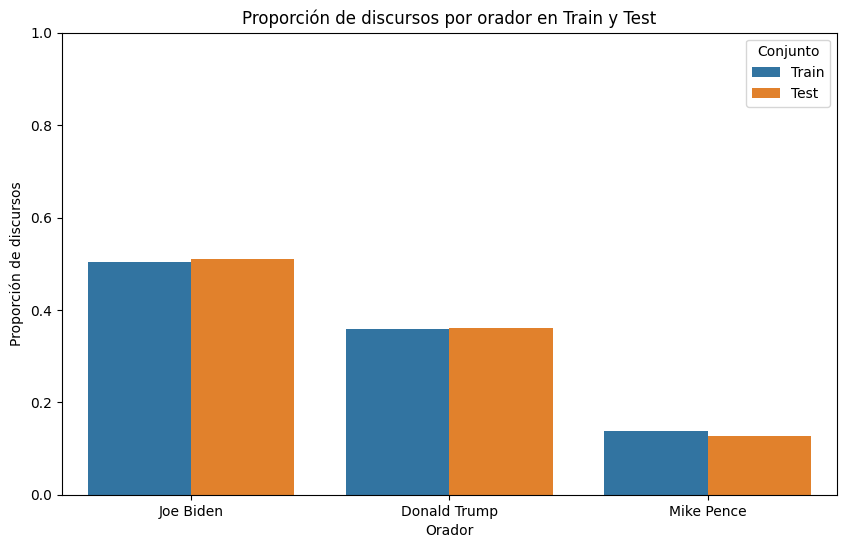

In [104]:
# 2: Visualización de la proporción de cada candidato por conjunto

# Contar la frecuencia de discursos por orador en train y test
train_counts = train_df['paragraph_speaker'].value_counts(normalize=True).reset_index()
train_counts.columns = ['paragraph_speaker', 'proportion']
train_counts['set'] = 'Train'

test_counts = test_df['paragraph_speaker'].value_counts(normalize=True).reset_index()
test_counts.columns = ['paragraph_speaker', 'proportion']
test_counts['set'] = 'Test'

# Unir ambos dataframes para graficar juntos
counts_df = pd.concat([train_counts, test_counts])

# Crear gráfico de barras comparando proporciones
plt.figure(figsize=(10,6))
sns.barplot(data=counts_df, x='paragraph_speaker', y='proportion', hue='set')

plt.title('Proporción de discursos por orador en Train y Test')
plt.ylabel('Proporción de discursos')
plt.xlabel('Orador')
plt.ylim(0, 1)
plt.legend(title='Conjunto')
plt.show()

#####3.

In [105]:
# 3: Transforme el texto del conjunto de entrenamiento a la representación numérica (features) de conteo de palabras o bag of words.

# Crear el vectorizador
vectorizer = CountVectorizer()

# Ajustar el vectorizador y transformar el texto de entrenamiento
X_train_bow = vectorizer.fit_transform(X_dev)

# X_train_bow es una matriz dispersa con la representación numérica de los textos
print(f"Shape de la matriz BoW: {X_train_bow.shape}")
print(f"Primeros diez elementos:")

#
n = 10
X_coo = X_train_bow.tocoo()  # Convertir a formato COO para acceder a coordenadas

for i, (row, col, val) in enumerate(zip(X_coo.row, X_coo.col, X_coo.data)):
    print(f"  ({row}, {col})\t{val}")
    if i + 1 == n:
        break

Shape de la matriz BoW: (109, 11795)
Primeros diez elementos:
  (0, 10588)	94
  (0, 4102)	1
  (0, 7153)	1
  (0, 10616)	80
  (0, 9191)	12
  (0, 10587)	76
  (0, 10633)	29
  (0, 5730)	38
  (0, 10311)	2
  (0, 10727)	112


#####4.

In [106]:
# 4: Obtenga la representación numérica Term Frequency - Inverse Document Frequency.

from sklearn.feature_extraction.text import TfidfTransformer

"""Al crear el transformer con use_idf=False se desactiva el
cómputo del factor IDF y solo se calcula TF. Se ajusta a la matriz de conteos y se transforma:"""

# En nuestro caso X_train_bow es la matriz de conteos del conjunto "dev"
tf_transformer = TfidfTransformer(use_idf=False).fit(X_train_bow)
X_train_tf = tf_transformer.transform(X_train_bow)
#X_test_tf  = tf_transformer.transform(X_test_bow)

print("Dimensiones de la matriz con los Term Frequencies(TF) únicamente")
print(X_train_tf.shape)  # e.g. (n_samples_dev, n_features)
#print(X_test_tf.shape)   # idéntico número de columnas

#Aquí X_train_tf contiene las Term Frequencies normalizadas (cada fila suma 1),
#sin penalizar palabras muy frecuentes en todo el corpus.


#En el segundo enfoque, simplemente usamos el transformer por defecto (use_idf=True),
#y combinamos fit y transform en un único fit_transform, obteniendo la matriz TF–IDF de una vez:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_bow)
#X_test_tfidf  = tfidf_transformer.transform(X_test_bow)

print("Dimensiones de la matriz con TF-IDF")
print(X_train_tfidf.shape)  # mismo (n_samples_dev, n_features)
X_train_tfidf[10]



Dimensiones de la matriz con los Term Frequencies(TF) únicamente
(109, 11795)
Dimensiones de la matriz con TF-IDF
(109, 11795)


<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 505 stored elements and shape (1, 11795)>

#####5.

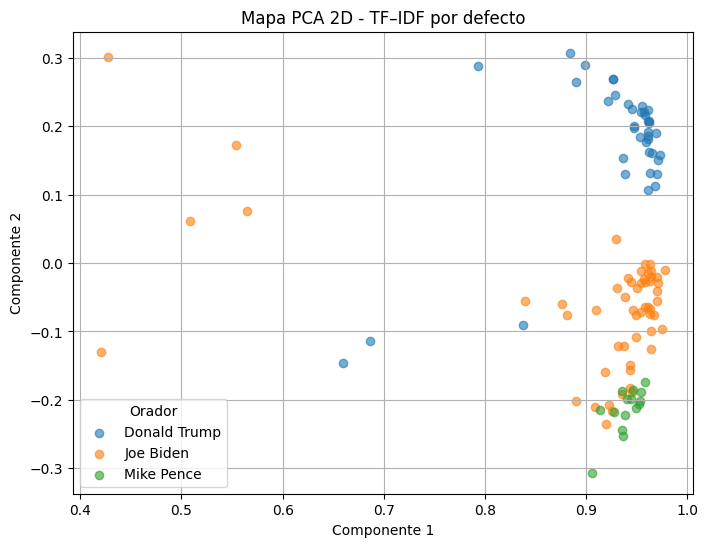

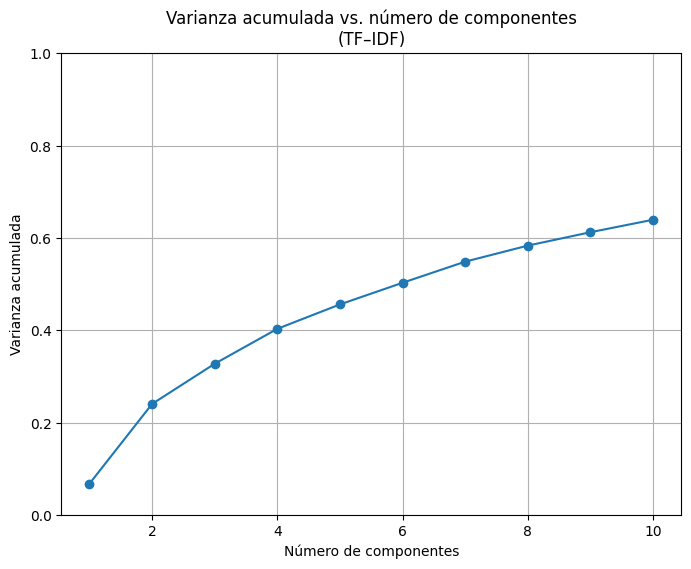

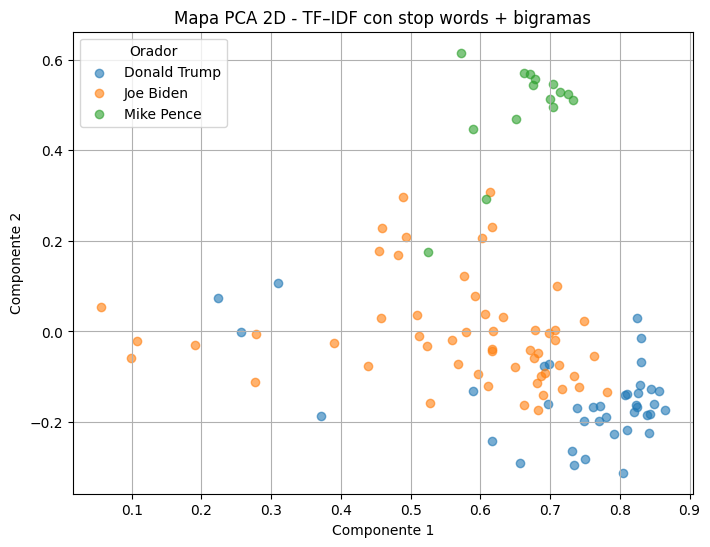

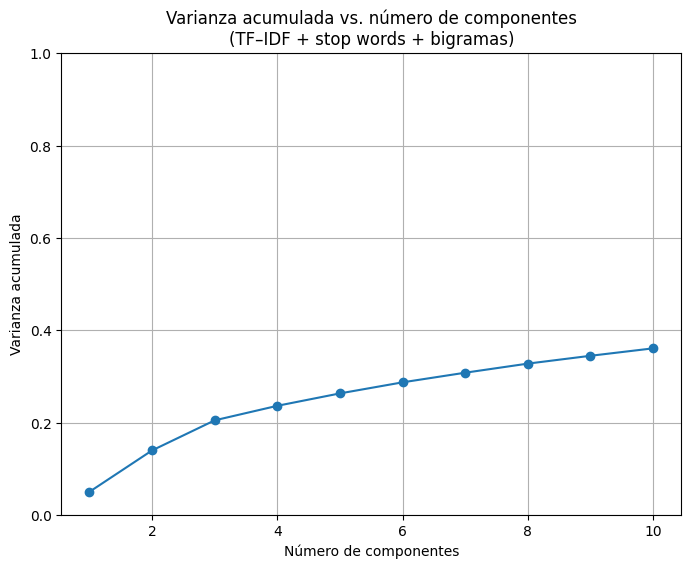

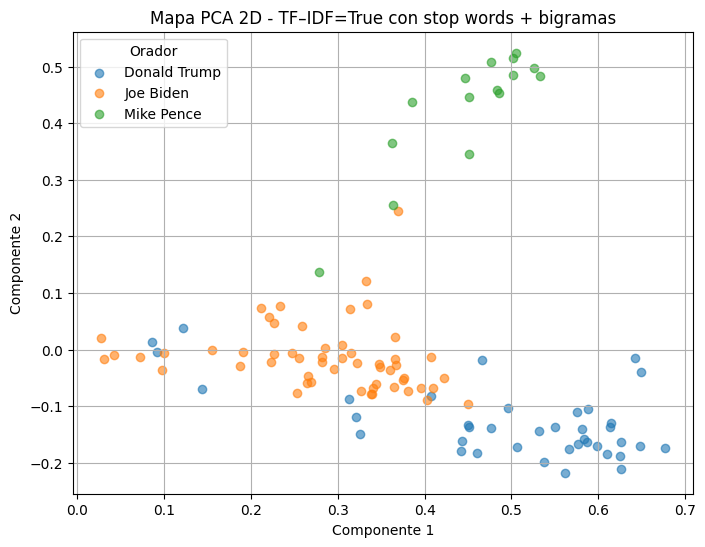

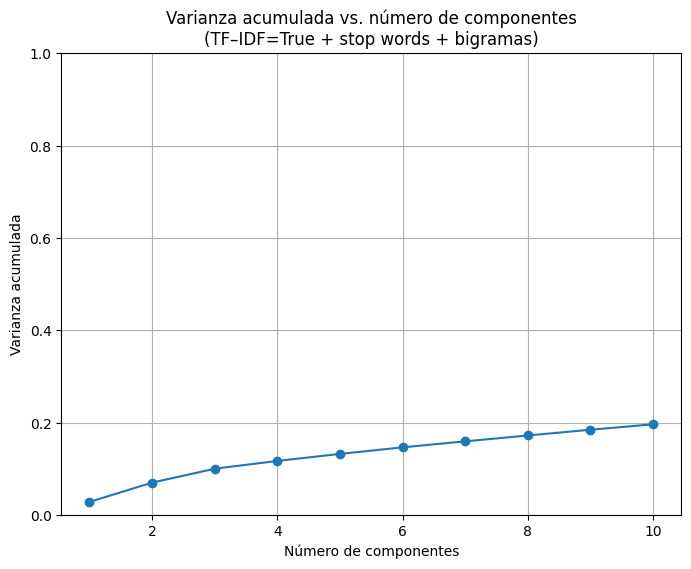

In [107]:
# 5 :Muestre en un mapa el conjunto de entrenamiento, utilizando las dos primeras componentes PCA sobre los vectores de tf-idf.
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import TruncatedSVD

# -------------------------------------------------------------------
# 1) Mostrar en un "mapa" (scatter plot) las dos primeras componentes PCA
#    sobre los vectores TF–IDF del conjunto de desarrollo (X_dev).
# -------------------------------------------------------------------

# 1.1 Vectorización y TF–IDF por defecto (sin stop words, unigramas)
vectorizer_default = CountVectorizer()
X_counts_default = vectorizer_default.fit_transform(X_dev)

tfidf_default = TfidfTransformer(use_idf=False)
X_tfidf_default = tfidf_default.fit_transform(X_counts_default)

# 1.2 Proyección a 2 componentes con TruncatedSVD (equivalente a PCA para datos sparse)
pca_default = TruncatedSVD(n_components=2, random_state=42)
X_pca_default = pca_default.fit_transform(X_tfidf_default)

# 1.3 Scatter plot coloreado por candidato
plt.figure(figsize=(8,6))
for speaker in y_dev.unique():
    mask = (y_dev == speaker)
    plt.scatter(
        X_pca_default[mask, 0],
        X_pca_default[mask, 1],
        label=speaker,
        alpha=0.6
    )
plt.title('Mapa PCA 2D - TF–IDF por defecto')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.legend(title='Orador')
plt.grid(True)
plt.show()


# -------------------------------------------------------------------
# 2) Curva de varianza explicada (acumulada) hasta 10 componentes
# -------------------------------------------------------------------

# 2.1 Ajustar PCA (TruncatedSVD) con 10 dimensiones sobre la variante
pca_default_explained = TruncatedSVD(n_components=10, random_state=42)
pca_default_explained.fit(X_tfidf_default)

# 2.2 Calcular varianza explicada acumulada
cum_variance = pca_default_explained.explained_variance_ratio_.cumsum()

# 2.3 Graficar la curva
plt.figure(figsize=(8,6))
plt.plot(range(1, 11), cum_variance, marker='o')
plt.title('Varianza acumulada vs. número de componentes\n(TF–IDF)')
plt.xlabel('Número de componentes')
plt.ylabel('Varianza acumulada')
plt.ylim(0,1)
plt.grid(True)
plt.show()


# -------------------------------------------------------------------
# 3) Repetir el "mapa" con filtrado de stop words (inglés) y bigramas
# -------------------------------------------------------------------

# 3.1 Vectorización con stop_words='english' y ngram_range=(1,2)
vectorizer_variant = CountVectorizer(stop_words='english', ngram_range=(1,2))
X_counts_variant = vectorizer_variant.fit_transform(X_dev)

tfidf_variant = TfidfTransformer(use_idf=False)
X_tfidf_variant = tfidf_variant.fit_transform(X_counts_variant)

# 3.2 PCA 2D sobre esta nueva matriz
pca_variant = TruncatedSVD(n_components=2, random_state=42)
X_pca_variant = pca_variant.fit_transform(X_tfidf_variant)

# 3.3 Scatter plot para comparar
plt.figure(figsize=(8,6))
for speaker in y_dev.unique():
    mask = (y_dev == speaker)
    plt.scatter(
        X_pca_variant[mask, 0],
        X_pca_variant[mask, 1],
        label=speaker,
        alpha=0.6
    )
plt.title('Mapa PCA 2D - TF–IDF con stop words + bigramas')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.legend(title='Orador')
plt.grid(True)
plt.show()


# Haga una visualización que permita entender cómo varía la varianza explicada a medida que se agregan componentes (e.g: hasta 10 componentes).

# -------------------------------------------------------------------
# 4) Curva de varianza explicada (acumulada) hasta 10 componentes
# -------------------------------------------------------------------



# 4.1 Ajustar PCA (TruncatedSVD) con 10 dimensiones sobre la variante
pca_explained = TruncatedSVD(n_components=10, random_state=42)
pca_explained.fit(X_tfidf_variant)

# 4.2 Calcular varianza explicada acumulada
cum_variance = pca_explained.explained_variance_ratio_.cumsum()

# 4.3 Graficar la curva
plt.figure(figsize=(8,6))
plt.plot(range(1, 11), cum_variance, marker='o')
plt.title('Varianza acumulada vs. número de componentes\n(TF–IDF + stop words + bigramas)')
plt.xlabel('Número de componentes')
plt.ylabel('Varianza acumulada')
plt.ylim(0,1)
plt.grid(True)
plt.show()




# -------------------------------------------------------------------
# 5) Repetir el "mapa" con filtrado de stop words (inglés) y bigramas
# -------------------------------------------------------------------

# 3.1 Vectorización con stop_words='english' y ngram_range=(1,2)
vectorizer_variant = CountVectorizer(stop_words='english', ngram_range=(1,2))
X_counts_variant = vectorizer_variant.fit_transform(X_dev)

tfidf_variant = TfidfTransformer(use_idf=True)
X_tfidf_variant = tfidf_variant.fit_transform(X_counts_variant)

# 3.2 PCA 2D sobre esta nueva matriz
pca_variant = TruncatedSVD(n_components=2, random_state=42)
X_pca_variant = pca_variant.fit_transform(X_tfidf_variant)

# 3.3 Scatter plot para comparar
plt.figure(figsize=(8,6))
for speaker in y_dev.unique():
    mask = (y_dev == speaker)
    plt.scatter(
        X_pca_variant[mask, 0],
        X_pca_variant[mask, 1],
        label=speaker,
        alpha=0.6
    )
plt.title('Mapa PCA 2D - TF–IDF=True con stop words + bigramas')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.legend(title='Orador')
plt.grid(True)
plt.show()


# Haga una visualización que permita entender cómo varía la varianza explicada a medida que se agregan componentes (e.g: hasta 10 componentes).

# -------------------------------------------------------------------
# 6) Curva de varianza explicada (acumulada) hasta 10 componentes
# -------------------------------------------------------------------



# 4.1 Ajustar PCA (TruncatedSVD) con 10 dimensiones sobre la variante
pca_explained = TruncatedSVD(n_components=10, random_state=42)
pca_explained.fit(X_tfidf_variant)

# 4.2 Calcular varianza explicada acumulada
cum_variance = pca_explained.explained_variance_ratio_.cumsum()

# 4.3 Graficar la curva
plt.figure(figsize=(8,6))
plt.plot(range(1, 11), cum_variance, marker='o')
plt.title('Varianza acumulada vs. número de componentes\n(TF–IDF=True + stop words + bigramas)')
plt.xlabel('Número de componentes')
plt.ylabel('Varianza acumulada')
plt.ylim(0,1)
plt.grid(True)
plt.show()


##### Nueva Visualización de PCA(TruncatedSVD)

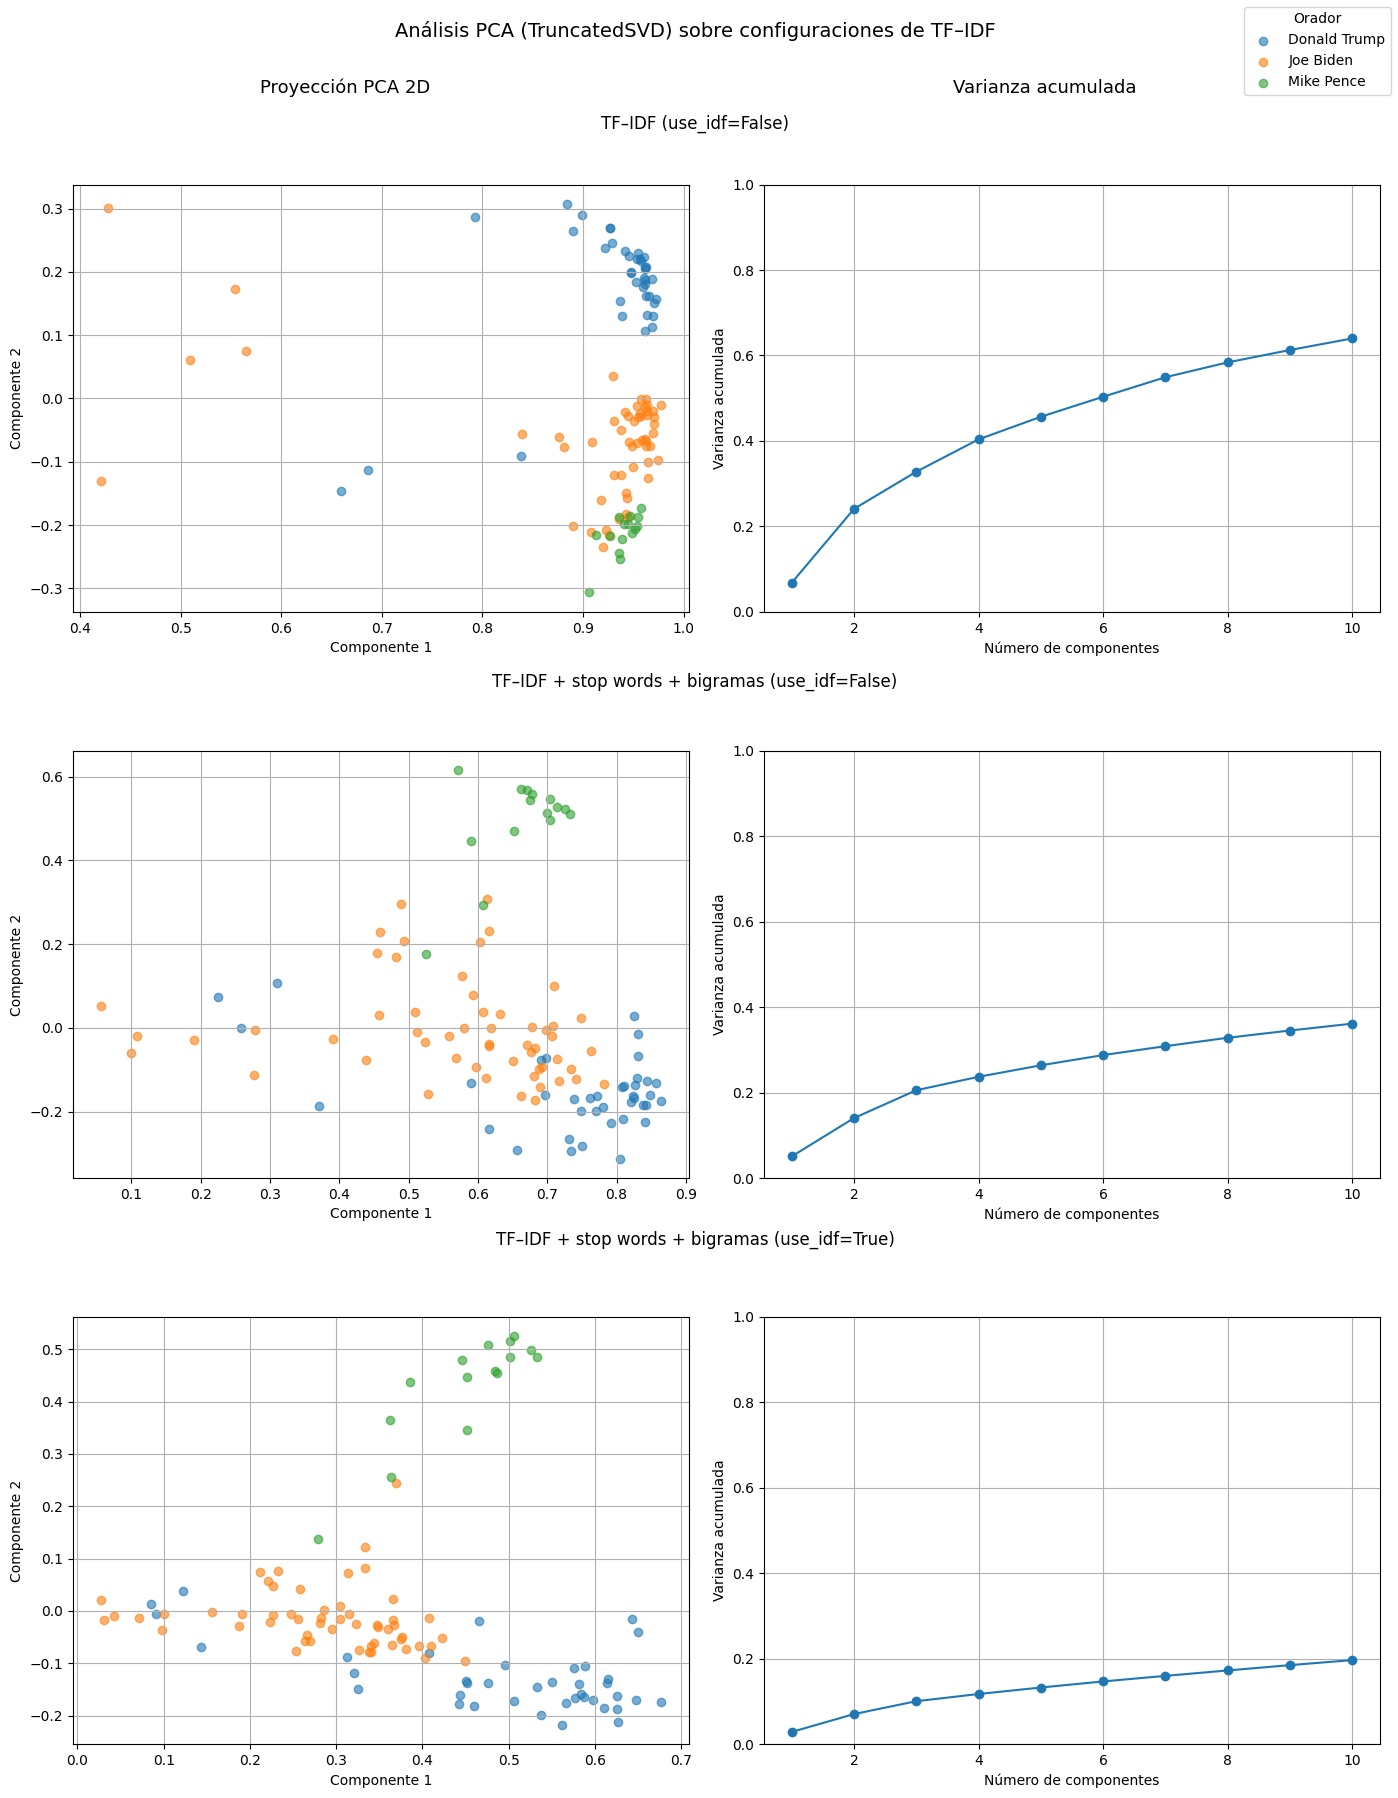

In [108]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import TruncatedSVD

# Configuraciones por fila
configurations = [
    {
        "desc": "TF–IDF (use_idf=False)",
        "vectorizer": CountVectorizer(),
        "tfidf": TfidfTransformer(use_idf=False),
    },
    {
        "desc": "TF–IDF + stop words + bigramas (use_idf=False)",
        "vectorizer": CountVectorizer(stop_words='english', ngram_range=(1, 2)),
        "tfidf": TfidfTransformer(use_idf=False),
    },
    {
        "desc": "TF–IDF + stop words + bigramas (use_idf=True)",
        "vectorizer": CountVectorizer(stop_words='english', ngram_range=(1, 2)),
        "tfidf": TfidfTransformer(use_idf=True),
    },
]

# Crear figura con GridSpec con espacio entre filas
fig = plt.figure(figsize=(14, 18))
gs = GridSpec(5, 2, height_ratios=[1, 0.05, 1, 0.05, 1], figure=fig)

axes = []

for i, config in enumerate(configurations):
    row_offset = i * 2  # filas 0, 2, 4
    # Vectorizar y transformar
    X_counts = config["vectorizer"].fit_transform(X_dev)
    X_tfidf = config["tfidf"].fit_transform(X_counts)

    # PCA 2D
    svd = TruncatedSVD(n_components=2, random_state=42)
    X_pca = svd.fit_transform(X_tfidf)

    ax_scatter = fig.add_subplot(gs[row_offset, 0])
    for speaker in y_dev.unique():
        mask = (y_dev == speaker)
        ax_scatter.scatter(X_pca[mask, 0], X_pca[mask, 1], label=speaker, alpha=0.6)
    ax_scatter.set_xlabel("Componente 1")
    ax_scatter.set_ylabel("Componente 2")
    ax_scatter.grid(True)
    axes.append(ax_scatter)

    # Varianza acumulada
    svd_var = TruncatedSVD(n_components=10, random_state=42)
    svd_var.fit(X_tfidf)
    cum_var = svd_var.explained_variance_ratio_.cumsum()

    ax_var = fig.add_subplot(gs[row_offset, 1])
    ax_var.plot(range(1, 11), cum_var, marker='o')
    ax_var.set_xlabel("Número de componentes")
    ax_var.set_ylabel("Varianza acumulada")
    ax_var.set_ylim(0, 1)
    ax_var.grid(True)
    axes.append(ax_var)

    # Agregar título de fila centrado entre ambos gráficos
    fig.text(0.5, 1 - 0.31 * i - 0.07, config["desc"], ha='center', fontsize=12)

# Títulos de columnas
fig.text(0.25, 0.95, "Proyección PCA 2D", ha='center', fontsize=13)
fig.text(0.75, 0.95, "Varianza acumulada", ha='center', fontsize=13)

# Título global
fig.suptitle("Análisis PCA (TruncatedSVD) sobre configuraciones de TF–IDF", fontsize=14, y=0.99)

# Leyenda global
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', title='Orador')

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.savefig("pca_gridspec_separado.png", dpi=300)
plt.show()

#####PCA clásica

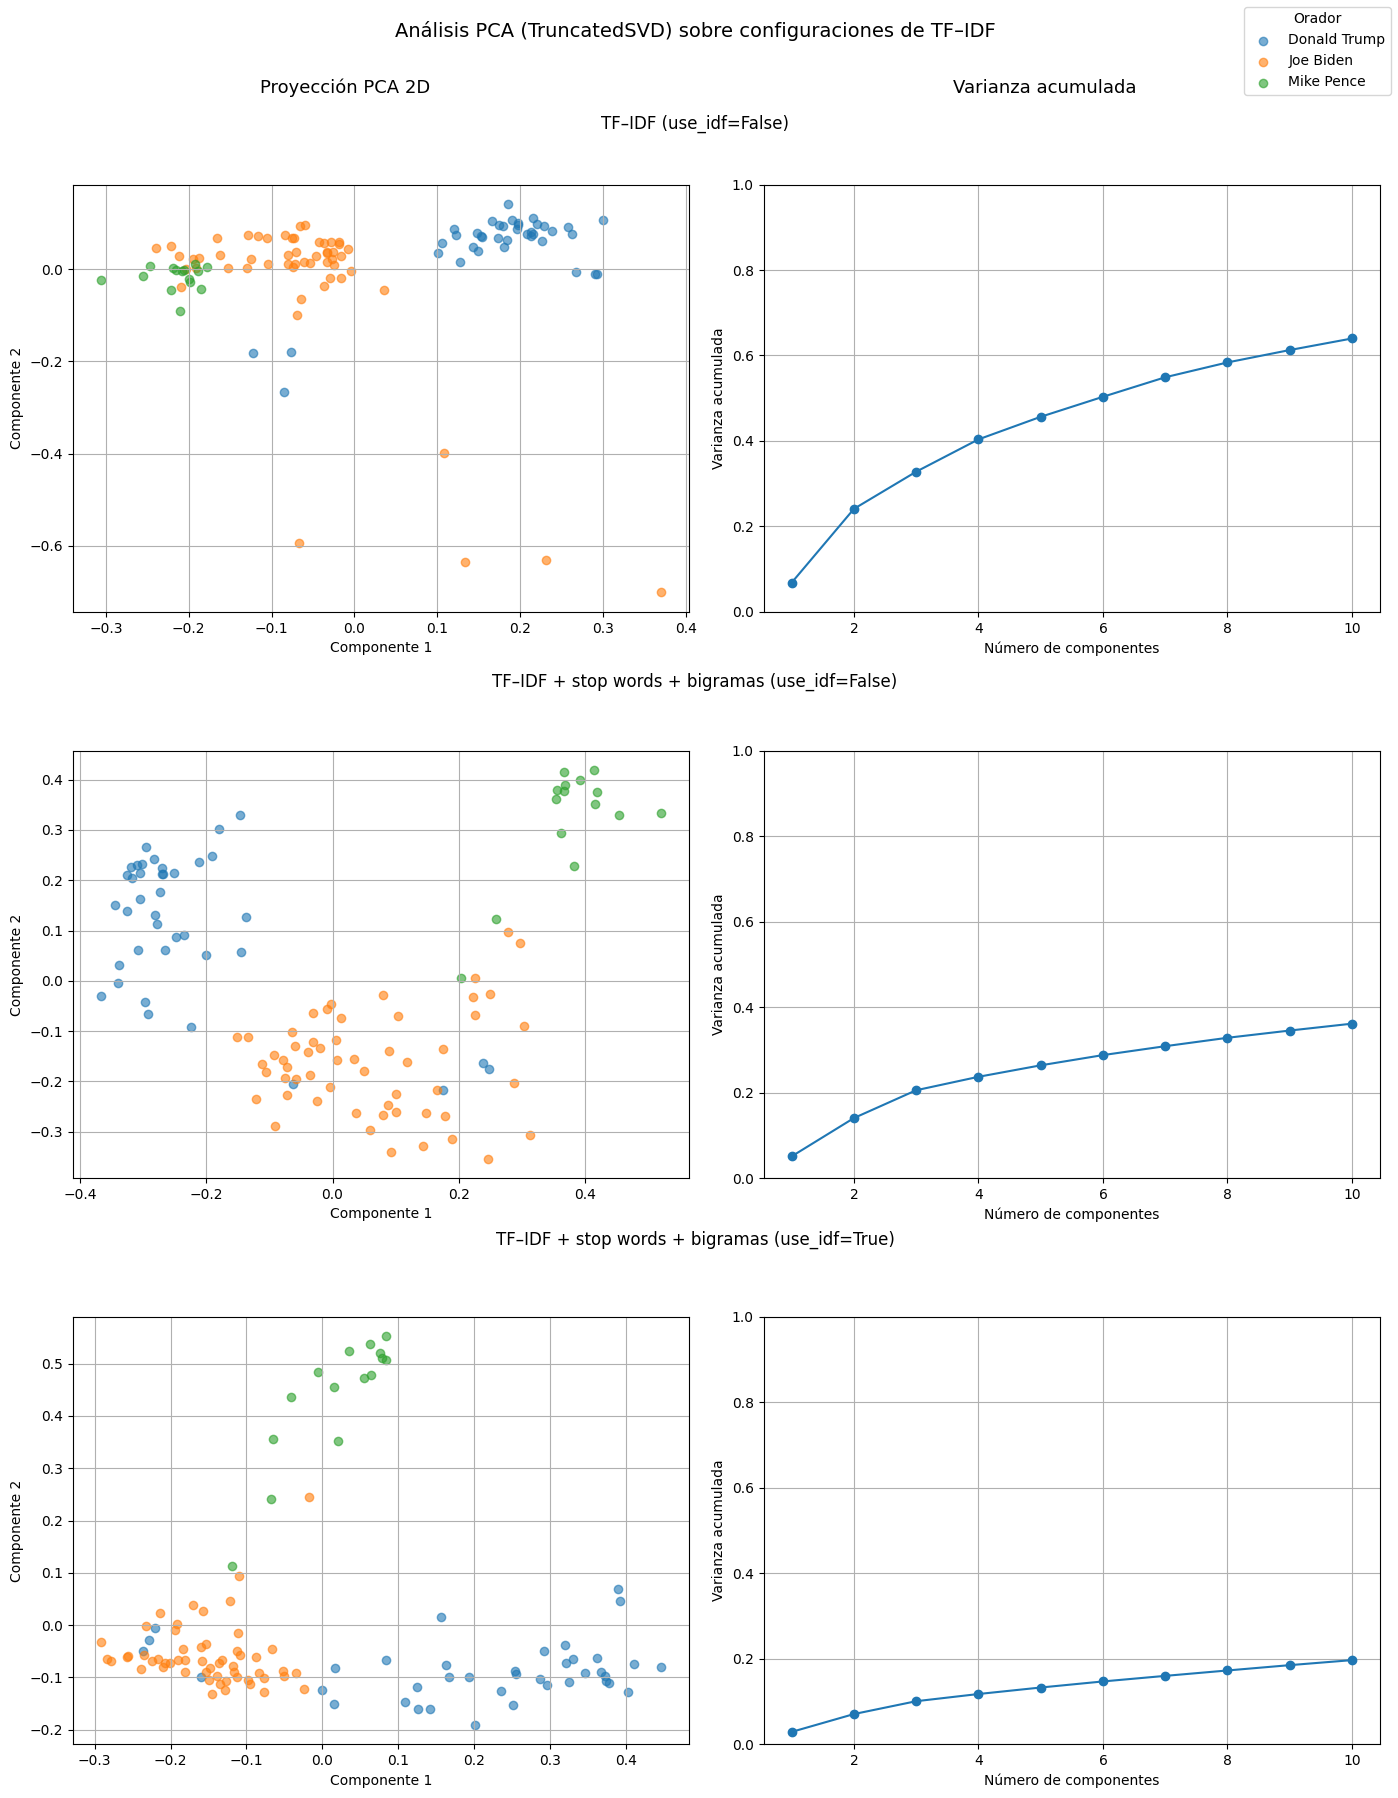

In [109]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer

# Configuraciones por fila
configurations = [
    {
        "desc": "TF–IDF (use_idf=False)",
        "vectorizer": CountVectorizer(),
        "tfidf": TfidfTransformer(use_idf=False),
    },
    {
        "desc": "TF–IDF + stop words + bigramas (use_idf=False)",
        "vectorizer": CountVectorizer(stop_words='english', ngram_range=(1, 2)),
        "tfidf": TfidfTransformer(use_idf=False),
    },
    {
        "desc": "TF–IDF + stop words + bigramas (use_idf=True)",
        "vectorizer": CountVectorizer(stop_words='english', ngram_range=(1, 2)),
        "tfidf": TfidfTransformer(use_idf=True),
    },
]

# Crear figura con GridSpec con espacio entre filas
fig = plt.figure(figsize=(14, 18))
gs = GridSpec(5, 2, height_ratios=[1, 0.05, 1, 0.05, 1], figure=fig)

axes = []

for i, config in enumerate(configurations):
    row_offset = i * 2  # filas 0, 2, 4
    # Vectorizar y transformar
    X_counts = config["vectorizer"].fit_transform(X_dev_grouped)
    X_tfidf = config["tfidf"].fit_transform(X_counts)

    # Convertir matriz sparse a densa
    X_dense = X_tfidf.toarray()

    # Aplicar PCA clásico (requiere matriz densa)
    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(X_dense)

    ax_scatter = fig.add_subplot(gs[row_offset, 0])
    for speaker in y_dev.unique():
        mask = (y_dev == speaker)
        ax_scatter.scatter(X_pca[mask, 0], X_pca[mask, 1], label=speaker, alpha=0.6)
    ax_scatter.set_xlabel("Componente 1")
    ax_scatter.set_ylabel("Componente 2")
    ax_scatter.grid(True)
    axes.append(ax_scatter)

    # Varianza acumulada
    svd_var = TruncatedSVD(n_components=10, random_state=42)
    svd_var.fit(X_tfidf)
    cum_var = svd_var.explained_variance_ratio_.cumsum()

    ax_var = fig.add_subplot(gs[row_offset, 1])
    ax_var.plot(range(1, 11), cum_var, marker='o')
    ax_var.set_xlabel("Número de componentes")
    ax_var.set_ylabel("Varianza acumulada")
    ax_var.set_ylim(0, 1)
    ax_var.grid(True)
    axes.append(ax_var)

    # Agregar título de fila centrado entre ambos gráficos
    fig.text(0.5, 1 - 0.31 * i - 0.07, config["desc"], ha='center', fontsize=12)

# Títulos de columnas
fig.text(0.25, 0.95, "Proyección PCA 2D", ha='center', fontsize=13)
fig.text(0.75, 0.95, "Varianza acumulada", ha='center', fontsize=13)

# Título global
fig.suptitle("Análisis PCA (TruncatedSVD) sobre configuraciones de TF–IDF", fontsize=14, y=0.99)

# Leyenda global
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', title='Orador')

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.savefig("pca_gridspec_separado.png", dpi=300)
plt.show()


#####Opcional:

Shape de la matriz BoW: (109, 13374)


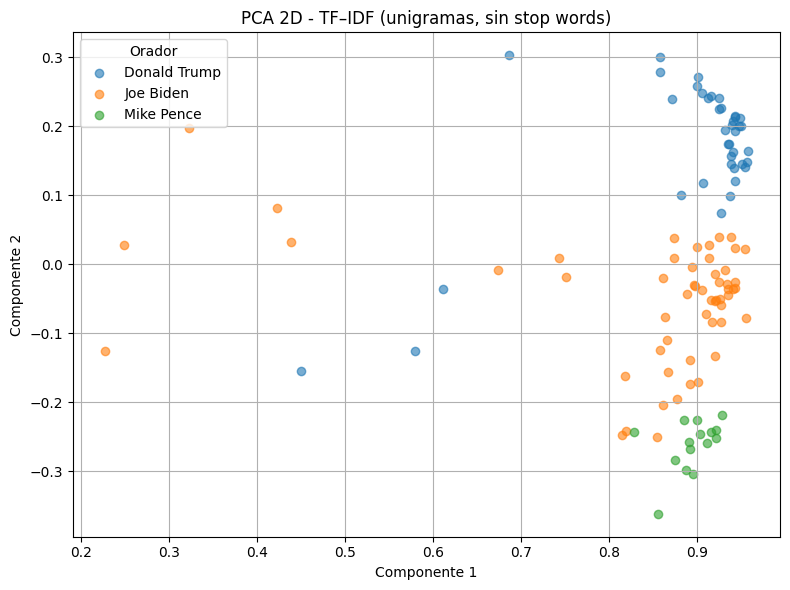

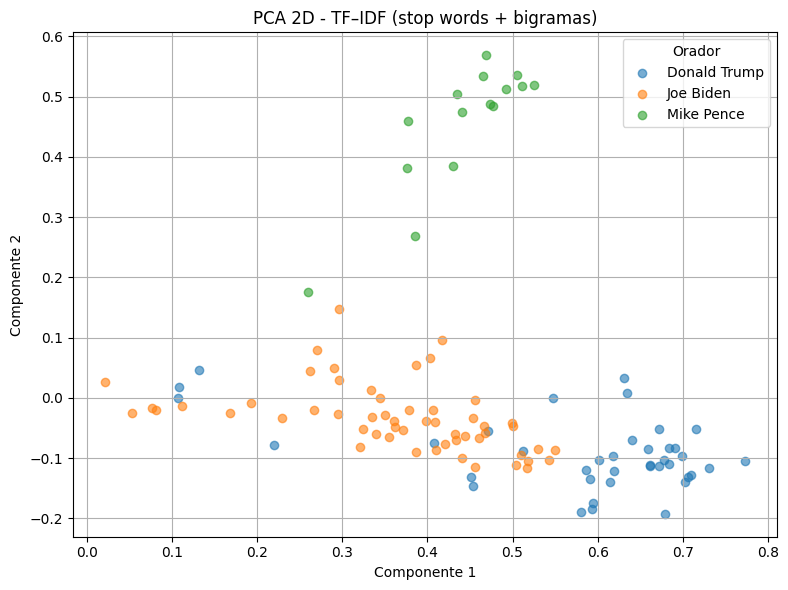

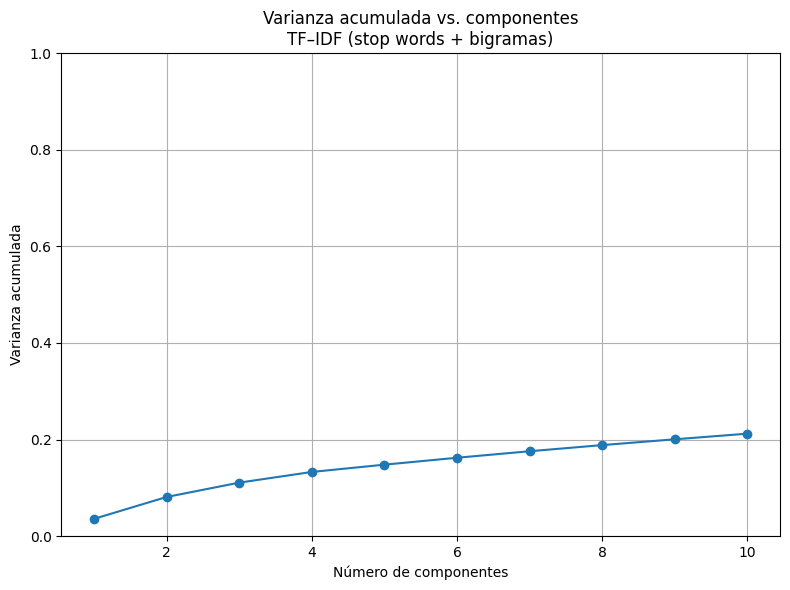

No cambia mucho


In [110]:
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import TruncatedSVD

# Usaremos las variables X_dev_grouped y y_dev_grouped definidas previamente
texts = X_dev_grouped
labels = y_dev_grouped

# ---------------------------------------------------------------
# 1) Proyección PCA 2D de TF–IDF por defecto (unigramas, sin stop words)
# ---------------------------------------------------------------
# 1.1 Vectorización bag-of-words (unigramas)
vectorizer_default_p = CountVectorizer(token_pattern=r"(?u)\b\w[\w.,!?;:'\"-]*\b")
X_counts_default_p = vectorizer_default_p.fit_transform(texts)
print(f"Shape de la matriz BoW: {X_counts_default_p.shape}") ## funciona

# 1.2 Transformación a TF–IDF
tfidf_default_p = TfidfTransformer(use_idf=True)
X_tfidf_default_p = tfidf_default_p.fit_transform(X_counts_default_p)

# 1.3 Reducción a 2 componentes con TruncatedSVD
svd_default_p = TruncatedSVD(n_components=2, random_state=42)
X_pca_default_p = svd_default_p.fit_transform(X_tfidf_default_p)

# 1.4 Scatter plot coloreado por candidato
plt.figure(figsize=(8,6))
for speaker in labels.unique():
    mask = (labels == speaker)
    plt.scatter(
        X_pca_default_p[mask, 0],
        X_pca_default_p[mask, 1],
        label=speaker,
        alpha=0.6
    )
plt.title('PCA 2D - TF–IDF (unigramas, sin stop words)')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.legend(title='Orador')
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------------------------------------------------------------
# 2) Proyección PCA 2D con stop_words='english' y ngram_range=(1,2)
# ---------------------------------------------------------------
# 2.1 Vectorización con stop words y bigramas
vectorizer_variant_p = CountVectorizer(stop_words='english', ngram_range=(1,2),token_pattern=r"(?u)\b\w[\w.,!?;:'\"-]*\b")
X_counts_variant_p = vectorizer_variant_p.fit_transform(texts)

# 2.2 Transformación a TF–IDF
tfidf_variant_p = TfidfTransformer(use_idf=True)
X_tfidf_variant_p = tfidf_variant_p.fit_transform(X_counts_variant_p)

# 2.3 Reducción a 2 componentes
svd_variant_p = TruncatedSVD(n_components=2, random_state=42)
X_pca_variant_p = svd_variant_p.fit_transform(X_tfidf_variant_p)

# 2.4 Scatter plot para la variante
plt.figure(figsize=(8,6))
for speaker in labels.unique():
    mask = (labels == speaker)
    plt.scatter(
        X_pca_variant_p[mask, 0],
        X_pca_variant_p[mask, 1],
        label=speaker,
        alpha=0.6
    )
plt.title('PCA 2D - TF–IDF (stop words + bigramas)')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.legend(title='Orador')
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------------------------------------------------------------
# 3) Curva de varianza acumulada hasta 10 componentes (variante)
# ---------------------------------------------------------------
svd_explained = TruncatedSVD(n_components=10, random_state=42)
svd_explained.fit(X_tfidf_variant_p)
cum_variance = svd_explained.explained_variance_ratio_.cumsum()

plt.figure(figsize=(8,6))
plt.plot(range(1, 11), cum_variance, marker='o')
plt.title('Varianza acumulada vs. componentes\nTF–IDF (stop words + bigramas)')
plt.xlabel('Número de componentes')
plt.ylabel('Varianza acumulada')
plt.ylim(0,1)
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"No cambia mucho")


## Parte 2: Entrenamiento y Evaluación de Modelos


#####1.

=== Resultados con TF-IDF simple ===
Accuracy: 0.5106


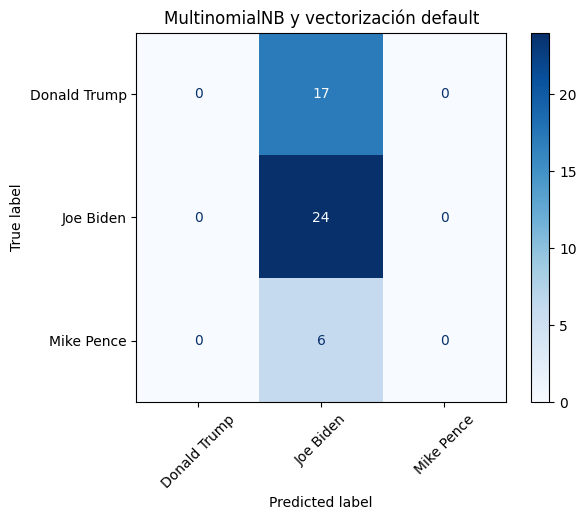

              precision    recall  f1-score   support

Donald Trump       0.00      0.00      0.00        17
   Joe Biden       0.51      1.00      0.68        24
  Mike Pence       0.00      0.00      0.00         6

    accuracy                           0.51        47
   macro avg       0.17      0.33      0.23        47
weighted avg       0.26      0.51      0.35        47



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



=== Resultados con TF-IDF (stop_words + n-gramas) ===
Accuracy: 0.8511


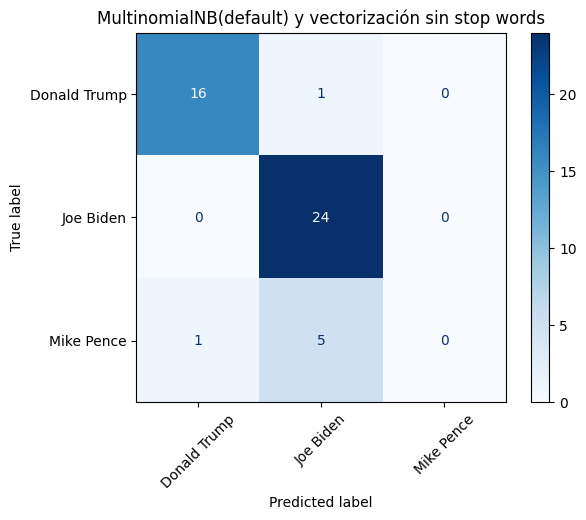

              precision    recall  f1-score   support

Donald Trump       0.94      0.94      0.94        17
   Joe Biden       0.80      1.00      0.89        24
  Mike Pence       0.00      0.00      0.00         6

    accuracy                           0.85        47
   macro avg       0.58      0.65      0.61        47
weighted avg       0.75      0.85      0.79        47



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [111]:
# 1: Entrene el modelo Multinomial Naive Bayes, luego utilícelo para predecir sobre el conjunto de test, y reporte el valor de accuracy y la matriz de confusión. Reporte el valor de precision y recall para cada candidato.
# Calcular matriz de confusión Sugerencia: utilice el método from_predictions de ConfusionMatrixDisplay para realizar la matriz.

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, classification_report


# Vectorización simple
vectorizer = TfidfVectorizer()
X_dev_tfidf = vectorizer.fit_transform(X_dev)
X_test_tfidf = vectorizer.transform(X_test)

# Entrenar modelo
clf = MultinomialNB()
clf.fit(X_dev_tfidf, y_dev)

# Predecir
y_pred = clf.predict(X_test_tfidf)

# Evaluar
print("=== Resultados con TF-IDF simple ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
ConfusionMatrixDisplay.from_predictions(y_test, y_pred,cmap='Blues', xticks_rotation=45)
plt.title("MultinomialNB y vectorización default")
plt.show()
print(classification_report(y_test, y_pred))



# # Vectorización mejorada
vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 1) )
X_dev_tfidf = vectorizer.fit_transform(X_dev)
X_test_tfidf = vectorizer.transform(X_test)

# Entrenar modelo
clf = MultinomialNB()
clf.fit(X_dev_tfidf, y_dev)

# # Predecir
y_pred = clf.predict(X_test_tfidf)

# # Evaluar
print("\n=== Resultados con TF-IDF (stop_words + n-gramas) ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Blues", xticks_rotation=45)
plt.title("MultinomialNB(default) y vectorización sin stop words")
plt.show()
print(classification_report(y_test, y_pred))


###### Anlisis de resultados
En una primera instancia, el modelo Multinomial Naive Bayes fue incapaz de distinguir entre los tres oradores: clasificó todos los discursos como pertenecientes a Joe Biden. Este comportamiento se vio reflejado tanto en la matriz de confusión como en el reporte de métricas, donde las clases Donald Trump y Mike Pence obtuvieron valores nulos en precision y recall.

Sin embargo, al modificar la configuración del vectorizador TF-IDF —por ejemplo, incluyendo stop_words='english' y ngram_range=(1,2)—, el rendimiento del modelo mejoró de forma considerable. Esta nueva representación permitió capturar mejor el estilo lingüístico de cada candidato. Como resultado, el modelo logró identificar correctamente discursos de Donald Trump (con recall de 0.94) y mantuvo un desempeño excelente para Joe Biden (recall de 1.00).

No obstante, la clase de Mike Pence continuó con valores nulos en las métricas, lo que evidencia una limitación del modelo para aprender sobre clases poco representadas en los datos. Este tipo de desbalance puede hacer que el modelo favorezca clases mayoritarias, incluso si se mejora la representación del texto.

Además, en esta implementación se utilizó MultinomialNB() con sus parámetros por defecto, lo que implica:

Un suavizado de Laplace (alpha=1.0), que evita que las palabras no observadas tengan probabilidad cero, permitiendo cierta generalización;

Y la opción fit_prior=True, que hace que el modelo aprenda automáticamente las probabilidades iniciales (a priori) de cada clase según la frecuencia en el conjunto de entrenamiento.

Esta combinación de hiperparámetros por defecto refuerza el sesgo hacia las clases más frecuentes. Por ejemplo, como hay una mayor cantidad de discursos de Joe Biden en el entrenamiento, el modelo tiende a asignar mayor probabilidad a esa clase desde el inicio, incluso antes de considerar las palabras. En contextos desbalanceados como este, esa preferencia inicial puede amplificarse si no se ajusta explícitamente el modelo o los datos.

En conjunto, los resultados muestran que tanto la calidad de la representación del texto como las decisiones por defecto del modelo impactan fuertemente en su comportamiento. Para abordar el problema del desbalance, será necesario considerar estrategias adicionales, como ajuste de priors, ponderación de clases o modificación del conjunto de entrenamiento.

#####2.

Fitting 5 folds for each of 16 candidates, totalling 80 fits
0.9929038281979459
{'clf__alpha': 0.01, 'clf__fit_prior': True, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 1), 'vect__stop_words': 'english'}


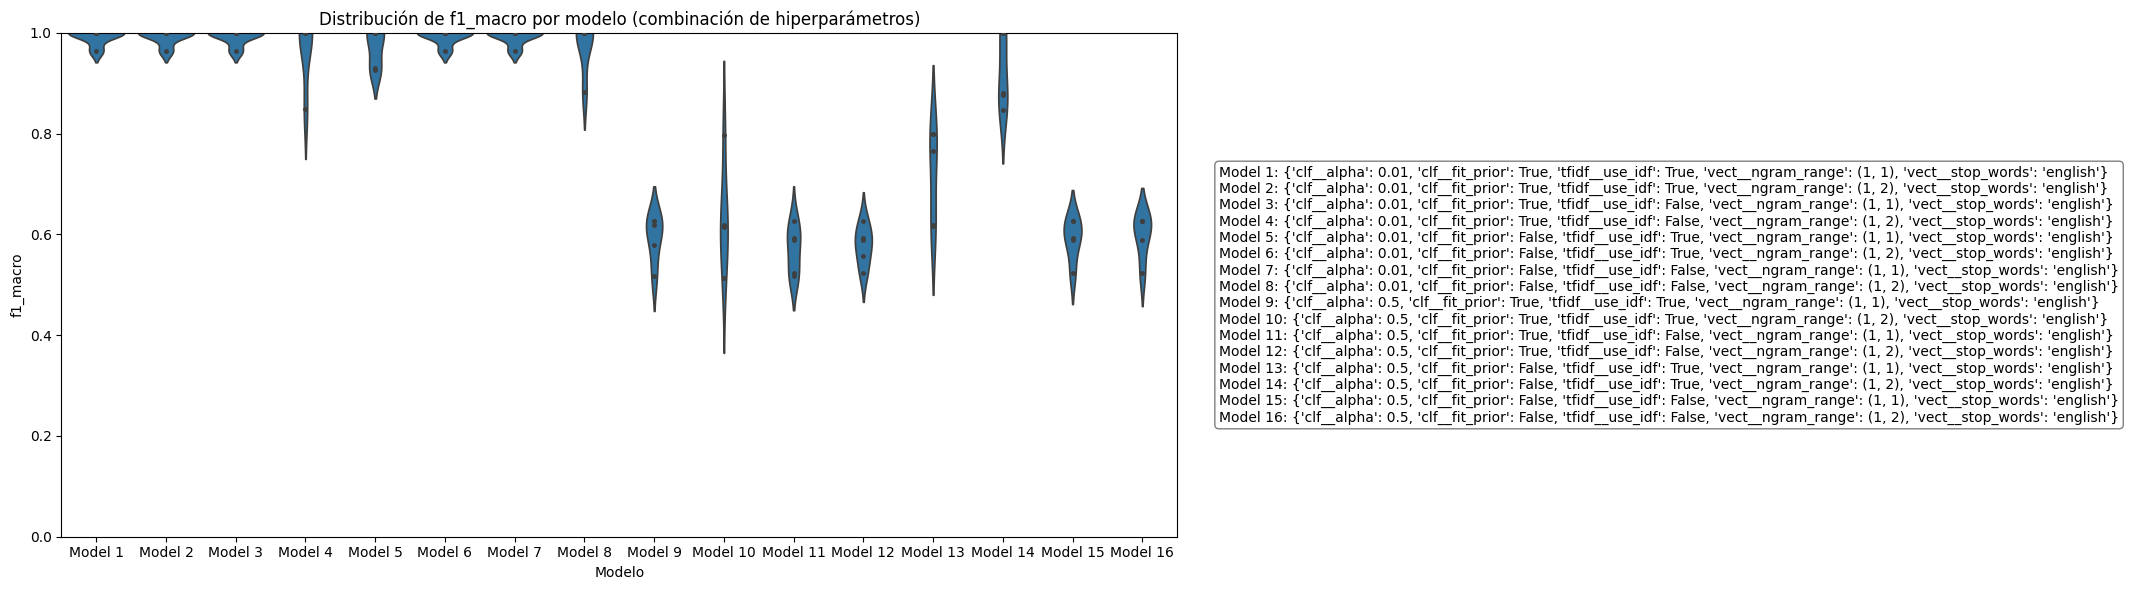

In [112]:
# 2: Implemente una búsqueda de hiperparámetros usando GridSearchCV.

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Definir pipeline
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB())
])

# Definir grid de parámetros a probar
param_grid = {
    'vect__ngram_range': [(1,1), (1,2)],
    'vect__stop_words': ['english'],# Unigramas o unigramas + bigramas
    'tfidf__use_idf': [True, False],            # Usar o no IDF
    'clf__alpha': [0.01, 0.5],
        'clf__fit_prior': [True, False] # Parámetro de suavizado del NB
}

# Instanciar GridSearchCV con validación cruzada 5 folds
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_macro', n_jobs=-1, verbose=1)

# Ajustar a datos de entrenamiento
grid_search.fit(X_dev, y_dev)

print(grid_search.best_score_)       # Mejor accuracy promedio en los 5 folds
print(grid_search.best_params_)     # Hiperparámetros que lograron ese score
pd.DataFrame(grid_search.cv_results_)        # Todos los resultados detallados


# Genere una visualización que permita comparar las métricas (e.g: accuracy) de los distintos modelos entrenados, viendo el valor promedio y variabilidad de las mismas en todos los splits (e.g: en un gráfico de violín).

# Extraer resultados
results = []
labels = []

for i, params in enumerate(grid_search.cv_results_['params']):
    label = f'Model {i+1}'
    labels.append((label, params))  # guardamos el label y los params
    for fold_idx in range(5):
        score = grid_search.cv_results_[f'split{fold_idx}_test_score'][i]
        results.append({
            'model': label,
            'f1_macro': score
        })

# Convertir a DataFrame
df_results = pd.DataFrame(results)

# Gráfico
plt.figure(figsize=(12, 6))
sns.violinplot(x='model', y='f1_macro', data=df_results, inner='point')
plt.ylim(0, 1)
plt.title('Distribución de f1_macro por modelo (combinación de hiperparámetros)')
plt.xlabel('Modelo')
plt.ylabel('f1_macro')
plt.xticks(rotation=0)

# Crear la leyenda como un cuadro al costado
legend_text = "\n".join([f"{label}: {params}" for label, params in labels])
plt.gcf().text(1.02, 0.5, legend_text, fontsize=10, va='center', bbox=dict(boxstyle="round", facecolor='white', edgecolor='gray'))

plt.tight_layout()
plt.show()

In [113]:
pd.DataFrame(grid_search.cv_results_)[['params', 'mean_test_score']]


,params,mean_test_score
0,"{'clf__alpha': 0.01, 'clf__fit_prior': True, '...",0.992904
1,"{'clf__alpha': 0.01, 'clf__fit_prior': True, '...",0.992904
2,"{'clf__alpha': 0.01, 'clf__fit_prior': True, '...",0.992904
3,"{'clf__alpha': 0.01, 'clf__fit_prior': True, '...",0.969638
4,"{'clf__alpha': 0.01, 'clf__fit_prior': False, ...",0.971274
5,"{'clf__alpha': 0.01, 'clf__fit_prior': False, ...",0.992904
6,"{'clf__alpha': 0.01, 'clf__fit_prior': False, ...",0.992904
7,"{'clf__alpha': 0.01, 'clf__fit_prior': False, ...",0.976684
8,"{'clf__alpha': 0.5, 'clf__fit_prior': True, 't...",0.593666
9,"{'clf__alpha': 0.5, 'clf__fit_prior': True, 't...",0.632091


Fitting 5 folds for each of 16 candidates, totalling 80 fits
0.990909090909091
{'clf__alpha': 0.01, 'clf__fit_prior': True, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 1), 'vect__stop_words': 'english'}


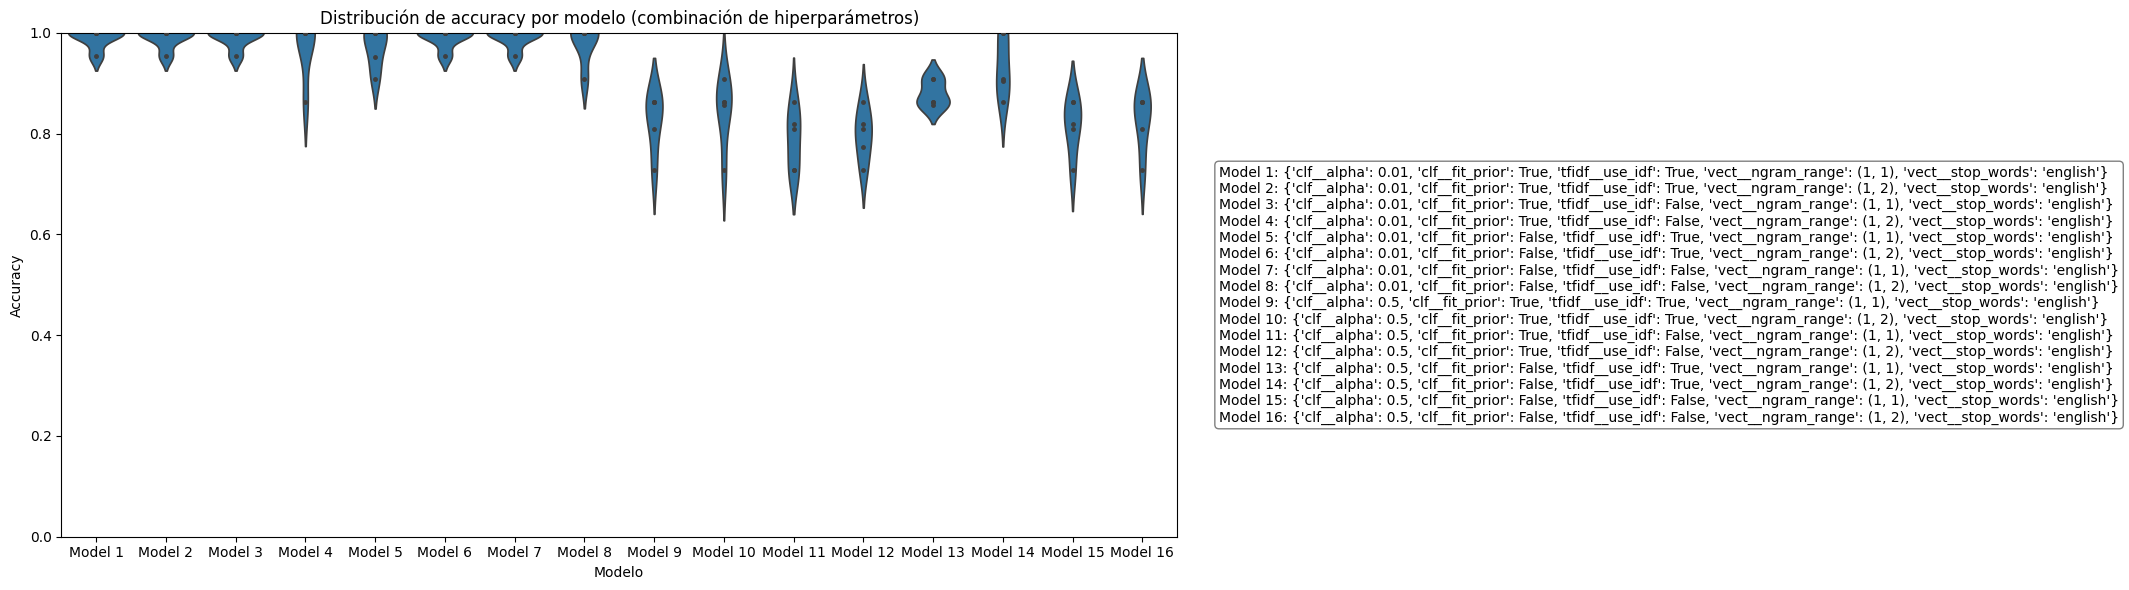

In [114]:
# 2: Implemente una búsqueda de hiperparámetros usando GridSearchCV.

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Definir pipeline
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB())
])

# Definir grid de parámetros a probar
param_grid = {
    'vect__ngram_range': [(1,1), (1,2)],
    'vect__stop_words': ['english'],# Unigramas o unigramas + bigramas
    'tfidf__use_idf': [True, False],            # Usar o no IDF
    'clf__alpha': [0.01, 0.5],
        'clf__fit_prior': [True, False] # Parámetro de suavizado del NB
}

# Instanciar GridSearchCV con validación cruzada 5 folds
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

# Ajustar a datos de entrenamiento
grid_search.fit(X_dev, y_dev)

print(grid_search.best_score_)       # Mejor accuracy promedio en los 5 folds
print(grid_search.best_params_)     # Hiperparámetros que lograron ese score
pd.DataFrame(grid_search.cv_results_)        # Todos los resultados detallados


# Genere una visualización que permita comparar las métricas (e.g: accuracy) de los distintos modelos entrenados, viendo el valor promedio y variabilidad de las mismas en todos los splits (e.g: en un gráfico de violín).

# Extraer resultados
results = []
labels = []

for i, params in enumerate(grid_search.cv_results_['params']):
    label = f'Model {i+1}'
    labels.append((label, params))  # guardamos el label y los params
    for fold_idx in range(5):
        score = grid_search.cv_results_[f'split{fold_idx}_test_score'][i]
        results.append({
            'model': label,
            'accuracy': score
        })

# Convertir a DataFrame
df_results = pd.DataFrame(results)

# Gráfico
plt.figure(figsize=(12, 6))
sns.violinplot(x='model', y='accuracy', data=df_results, inner='point')
plt.ylim(0, 1)
plt.title('Distribución de accuracy por modelo (combinación de hiperparámetros)')
plt.xlabel('Modelo')
plt.ylabel('Accuracy')
plt.xticks(rotation=0)

# Crear la leyenda como un cuadro al costado
legend_text = "\n".join([f"{label}: {params}" for label, params in labels])
plt.gcf().text(1.02, 0.5, legend_text, fontsize=10, va='center', bbox=dict(boxstyle="round", facecolor='white', edgecolor='gray'))

plt.tight_layout()
plt.show()

#####3.


=== Resultados con TF-IDF (stop_words + n-gramas) ===
Accuracy: 0.9574


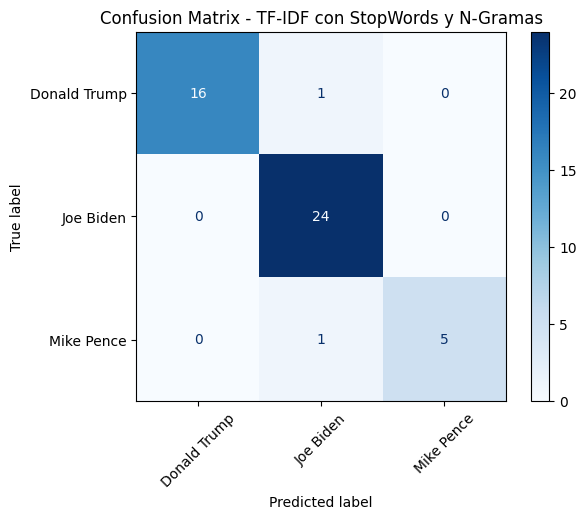

              precision    recall  f1-score   support

Donald Trump       1.00      0.94      0.97        17
   Joe Biden       0.92      1.00      0.96        24
  Mike Pence       1.00      0.83      0.91         6

    accuracy                           0.96        47
   macro avg       0.97      0.92      0.95        47
weighted avg       0.96      0.96      0.96        47



In [115]:
# 3: Elija el mejor modelo (mejores parámetros) y vuelva a entrenar sobre todo el conjunto de entrenamiento disponible (sin quitar datos para validación). Reporte el valor final de las métricas y la matriz de confusión.
# 1: Entrene el modelo Multinomial Naive Bayes, luego utilícelo para predecir sobre el conjunto de test, y reporte el valor de accuracy y la matriz de confusión. Reporte el valor de precision y recall para cada candidato.
# Calcular matriz de confusión Sugerencia: utilice el método from_predictions de ConfusionMatrixDisplay para realizar la matriz.

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, classification_report


# Vectorización mejorada
vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 1), use_idf=False)
X_dev_tfidf = vectorizer.fit_transform(X_dev)
X_test_tfidf = vectorizer.transform(X_test)

# Entrenar modelo
clf = MultinomialNB(alpha=0.01,fit_prior=True)
clf.fit(X_dev_tfidf, y_dev)

# Predecir
y_pred = clf.predict(X_test_tfidf)

# Evaluar
print("\n=== Resultados con TF-IDF (stop_words + n-gramas) ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix - TF-IDF con StopWords y N-Gramas")
plt.show()
print(classification_report(y_test, y_pred))


###### Discuta las limitaciones de utilizar un modelo basado en bag-of-words o tf-idf en cuanto al análisis de texto

El modelo seleccionado a partir de la búsqueda de hiperparámetros fue una combinación de TfidfVectorizer (con stop_words='english', ngram_range=(1,1)) y MultinomialNB con alpha=0.01 y fit_prior=True. Entrenado sobre el conjunto completo de entrenamiento y evaluado en el conjunto de test, obtuvo un accuracy de 0.9574 y un f1_macro de 0.92, con un desempeño equilibrado entre las clases, incluyendo una correcta identificación de la clase minoritaria (Mike Pence).

A pesar de estos buenos resultados, el enfoque basado en Bag-of-Words y TF-IDF presenta limitaciones importantes. En primer lugar, no considera el orden de las palabras. Esto significa que expresiones como “no es bueno” y “es bueno” pueden tener representaciones similares, lo cual puede ser problemático si el sentido del texto depende de la estructura sintáctica. Además, estas técnicas no capturan relaciones semánticas, como sinónimos, negaciones o matices de contexto, ya que tratan a cada palabra como una entidad independiente sin conexión con el entorno en el que aparece.

Otra limitación es que las representaciones generadas son sparse y de alta dimensionalidad, lo que puede llevar a ineficiencias computacionales y dificultar la generalización en contextos donde los datos son más escasos o ruidosos. Además, tanto BoW como TF-IDF son representaciones estáticas: no se adaptan ni aprenden del contexto específico de la tarea o del corpus.

En este caso particular, el modelo logró un muy buen rendimiento, lo que sugiere que existían diferencias suficientes entre los discursos para que una representación superficial bastara. Sin embargo, en tareas que requieren una comprensión más profunda del lenguaje, o cuando las clases se diferencian por sutilezas discursivas o semánticas, estos enfoques podrían no ser suficientes. Modelos más avanzados, como los basados en embeddings contextuales (por ejemplo, BERT), ofrecen una mayor capacidad de representar el lenguaje con riqueza estructural y semántica, y serían más adecuados en esos escenarios.

#####4.

In [116]:
# 4: Evalúe con validación cruzada al menos un modelo más (dentro de scikit-learn) aparte de Multinomial Naive Bayes para clasificar el texto utilizando las mismas features de texto.

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Definir el pipeline: TF-IDF + clasificador
pipeline = Pipeline([
    ('vect', TfidfVectorizer(stop_words='english', ngram_range=(1, 1))),
    ('clf', LogisticRegression(max_iter=1000))
])

# 2. Definir la grilla de hiperparámetros
param_grid = {
    'clf__C': [0.01, 0.1, 1.0, 10.0],
    'clf__class_weight': [None, 'balanced'],
    'clf__solver': ['lbfgs']  # seguro, robusto y rápido para conjuntos más pequeños
}

# 3. Ejecutar GridSearchCV
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    scoring='f1_macro',
    cv=5,
    return_train_score=True,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_dev, y_dev)

# 4. Mostrar los mejores resultados
print("Mejor combinación de hiperparámetros:", grid_search.best_params_)
print(f"Mejor f1_macro promedio (CV=5): {grid_search.best_score_:.4f}")


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Mejor combinación de hiperparámetros: {'clf__C': 0.01, 'clf__class_weight': 'balanced', 'clf__solver': 'lbfgs'}
Mejor f1_macro promedio (CV=5): 0.9525


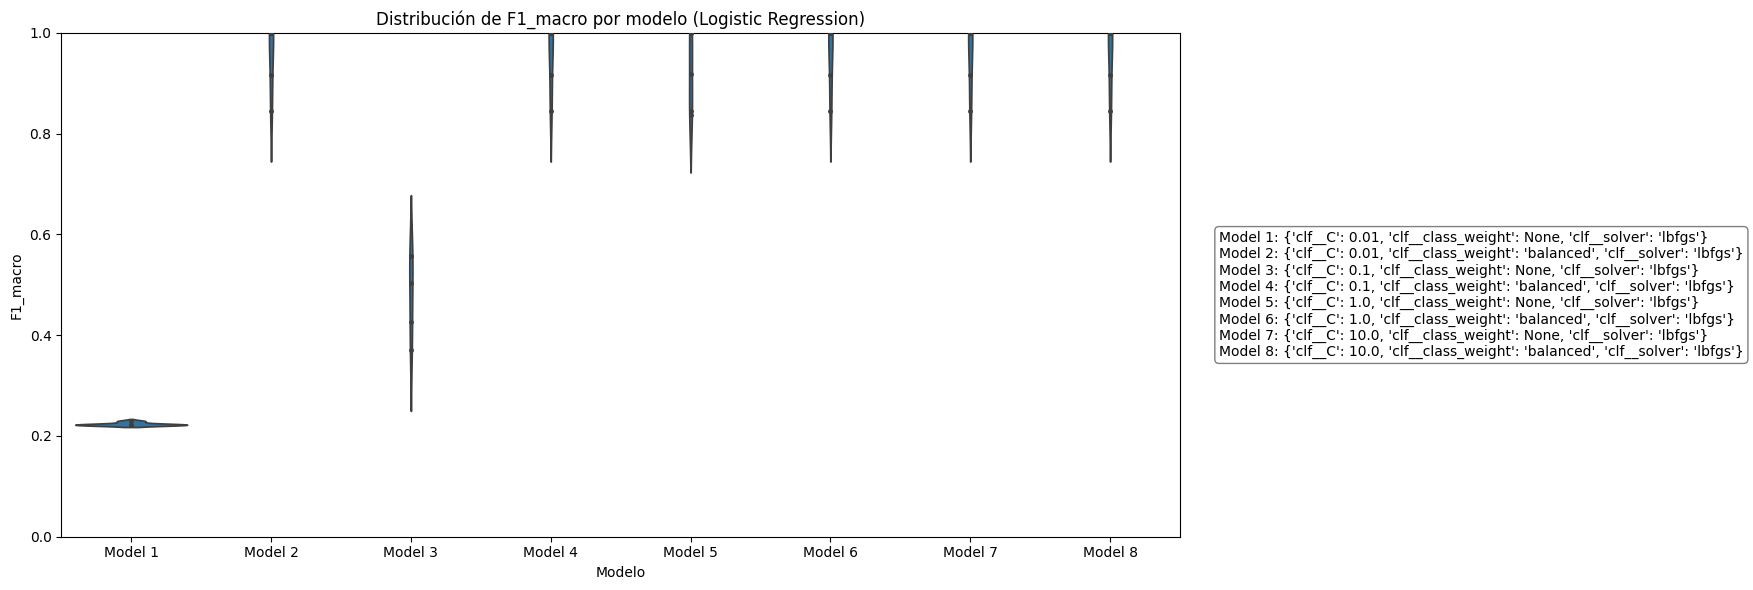

In [117]:
# 5. Extraer resultados fold por fold para graficar
results = []
labels = []

for i, params in enumerate(grid_search.cv_results_['params']):
    label = f'Model {i+1}'
    labels.append((label, params))
    for fold_idx in range(5):
        score = grid_search.cv_results_[f'split{fold_idx}_test_score'][i]
        results.append({
            'model': label,
            'f1_macro': score
        })

df_results = pd.DataFrame(results)

# 6. Graficar
plt.figure(figsize=(12, 6))
sns.violinplot(x='model', y='f1_macro', data=df_results, inner='point')
plt.ylim(0, 1)
plt.title('Distribución de F1_macro por modelo (Logistic Regression)')
plt.xlabel('Modelo')
plt.ylabel('F1_macro')

# Leyenda al costado
legend_text = "\n".join([f"{label}: {params}" for label, params in labels])
plt.gcf().text(1.02, 0.5, legend_text, fontsize=10, va='center',
               bbox=dict(boxstyle="round", facecolor='white', edgecolor='gray'))

plt.tight_layout()
plt.show()


In [118]:
# 4: Evalúe con validación cruzada al menos un modelo más (dentro de scikit-learn) aparte de Multinomial Naive Bayes para clasificar el texto utilizando las mismas features de texto.

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Definir el pipeline: TF-IDF + clasificador
pipeline = Pipeline([
    ('vect', TfidfVectorizer(stop_words='english', ngram_range=(1, 1))),
    ('clf', LogisticRegression(max_iter=1000))
])

# 2. Definir la grilla de hiperparámetros
param_grid = {
    'clf__C': [0.01, 0.1, 1.0, 10.0],
    'clf__class_weight': [None, 'balanced'],
    'clf__solver': ['lbfgs']  # seguro, robusto y rápido para conjuntos más pequeños
}

# 3. Ejecutar GridSearchCV
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    scoring='accuracy',
    cv=5,
    return_train_score=True,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_dev, y_dev)

# 4. Mostrar los mejores resultados
print("Mejor combinación de hiperparámetros:", grid_search.best_params_)
print(f"Mejor accuracy promedio (CV=5): {grid_search.best_score_:.4f}")


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Mejor combinación de hiperparámetros: {'clf__C': 0.01, 'clf__class_weight': 'balanced', 'clf__solver': 'lbfgs'}
Mejor accuracy promedio (CV=5): 0.9537


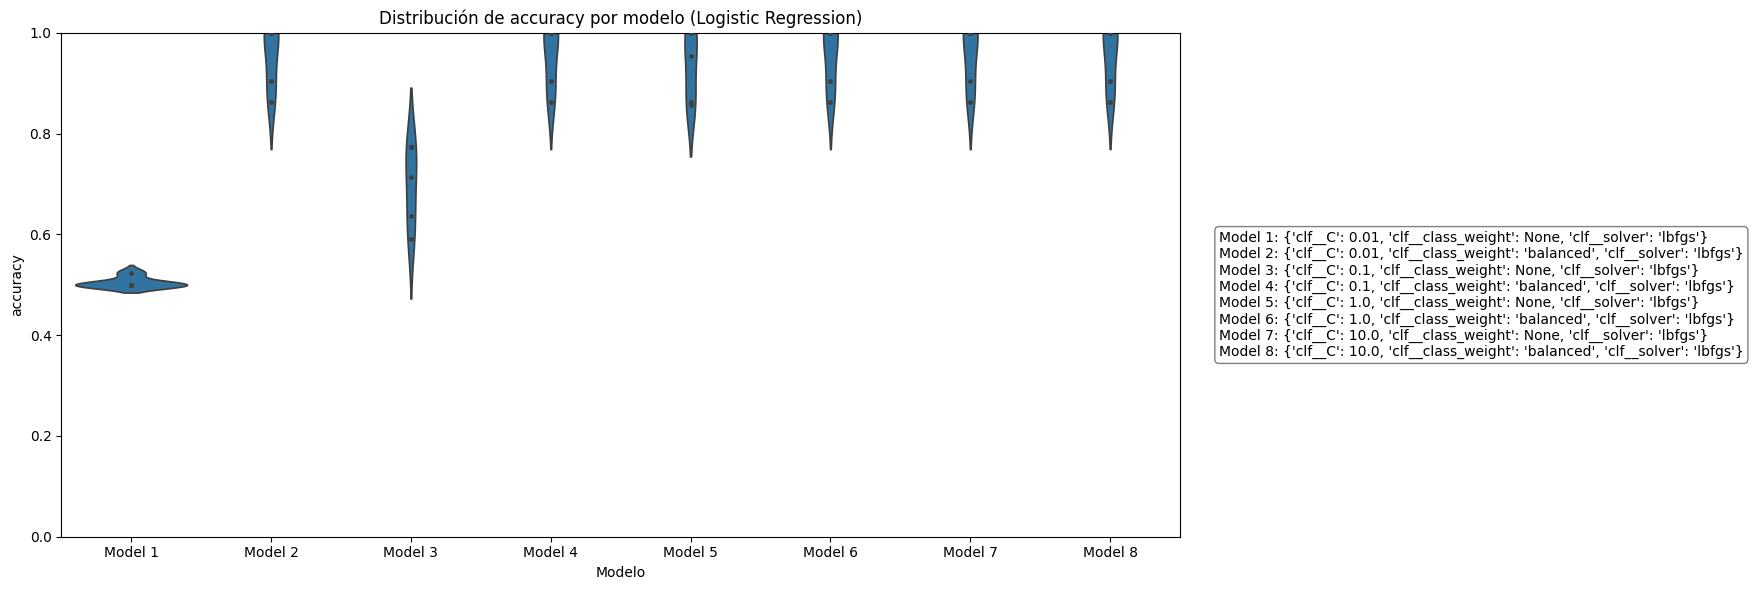

In [119]:
# 5. Extraer resultados fold por fold para graficar
results = []
labels = []

for i, params in enumerate(grid_search.cv_results_['params']):
    label = f'Model {i+1}'
    labels.append((label, params))
    for fold_idx in range(5):
        score = grid_search.cv_results_[f'split{fold_idx}_test_score'][i]
        results.append({
            'model': label,
            'accuracy': score
        })

df_results = pd.DataFrame(results)

# 6. Graficar
plt.figure(figsize=(12, 6))
sns.violinplot(x='model', y='accuracy', data=df_results, inner='point')
plt.ylim(0, 1)
plt.title('Distribución de accuracy por modelo (Logistic Regression)')
plt.xlabel('Modelo')
plt.ylabel('accuracy')

# Leyenda al costado
legend_text = "\n".join([f"{label}: {params}" for label, params in labels])
plt.gcf().text(1.02, 0.5, legend_text, fontsize=10, va='center',
               bbox=dict(boxstyle="round", facecolor='white', edgecolor='gray'))

plt.tight_layout()
plt.show()



=== Resultados con Logistic Regression ===
Accuracy: 0.9362


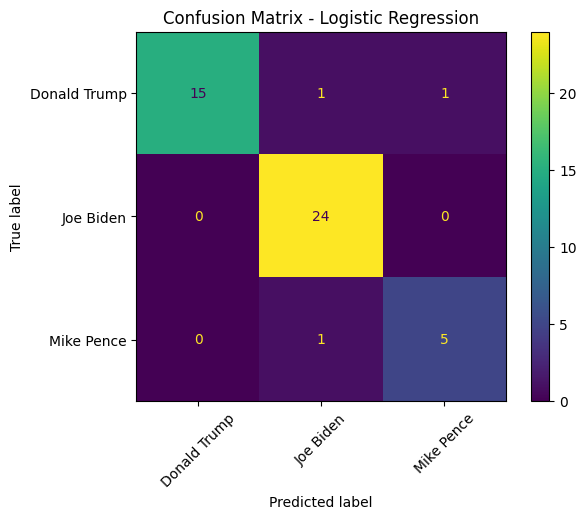

              precision    recall  f1-score   support

Donald Trump       1.00      0.88      0.94        17
   Joe Biden       0.92      1.00      0.96        24
  Mike Pence       0.83      0.83      0.83         6

    accuracy                           0.94        47
   macro avg       0.92      0.91      0.91        47
weighted avg       0.94      0.94      0.94        47



In [120]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

# 1. Vectorización (misma configuración usada antes)
vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 1))
X_dev_tfidf = vectorizer.fit_transform(X_dev)
X_test_tfidf = vectorizer.transform(X_test)

# 2. Entrenar Logistic Regression con mejores parámetros
clf = LogisticRegression(
    C=1.0,
    class_weight='balanced',
    solver='liblinear',
    max_iter=1000
)
clf.fit(X_dev_tfidf, y_dev)

# 3. Predecir en el test
y_pred = clf.predict(X_test_tfidf)

# 4. Evaluar
print("\n=== Resultados con Logistic Regression ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, xticks_rotation=45)
plt.title("Confusion Matrix - Logistic Regression")
plt.show()
print(classification_report(y_test, y_pred))


#####5.

Tamaño conjunto de entrenamiento: 84
Tamaño conjunto de test: 37

Distribución en entrenamiento:
paragraph_speaker
Joe Biden         0.654762
Mike Pence        0.178571
Bernie Sanders    0.166667
Name: proportion, dtype: float64

Distribución en test:
paragraph_speaker
Joe Biden         0.648649
Bernie Sanders    0.189189
Mike Pence        0.162162
Name: proportion, dtype: float64


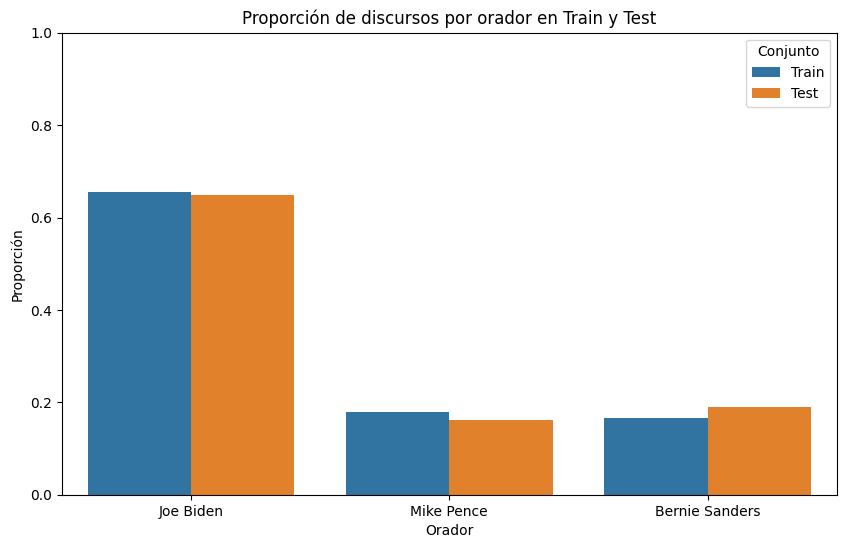

In [121]:
# 5: Evalúe el problema cambiando al menos un candidato. En particular, observe el (des)balance de datos y los problemas que pueda generar, así como cualquier indicio que pueda ver en el mapeo previo con PCA.

from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Filtrar por los oradores seleccionados
selected_speakers = ['Joe Biden', 'Mike Pence', 'Bernie Sanders']
df_selected = df_speeches_clean[df_speeches_clean['paragraph_speaker'].isin(selected_speakers)]

# 2. División estratificada en train y test
train_df_selected, test_df_selected = train_test_split(
    df_selected,
    test_size=0.3,
    stratify=df_selected['paragraph_speaker'],
    random_state=42
)

# 3. Mostrar tamaños de los conjuntos
print(f"Tamaño conjunto de entrenamiento: {train_df_selected.shape[0]}")
print(f"Tamaño conjunto de test: {test_df_selected.shape[0]}")

# 4. Mostrar distribución por orador (frecuencia relativa)
print("\nDistribución en entrenamiento:")
print(train_df_selected['paragraph_speaker'].value_counts(normalize=True))

print("\nDistribución en test:")
print(test_df_selected['paragraph_speaker'].value_counts(normalize=True))

# 5. Preparar datos para el gráfico
train_counts = train_df_selected['paragraph_speaker'].value_counts(normalize=True).reset_index()
train_counts.columns = ['paragraph_speaker', 'proportion']
train_counts['set'] = 'Train'

test_counts = test_df_selected['paragraph_speaker'].value_counts(normalize=True).reset_index()
test_counts.columns = ['paragraph_speaker', 'proportion']
test_counts['set'] = 'Test'

counts_df = pd.concat([train_counts, test_counts])

# 6. Gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(data=counts_df, x='paragraph_speaker', y='proportion', hue='set')
plt.title('Proporción de discursos por orador en Train y Test')
plt.ylabel('Proporción')
plt.xlabel('Orador')
plt.ylim(0, 1)
plt.legend(title='Conjunto')
plt.show()


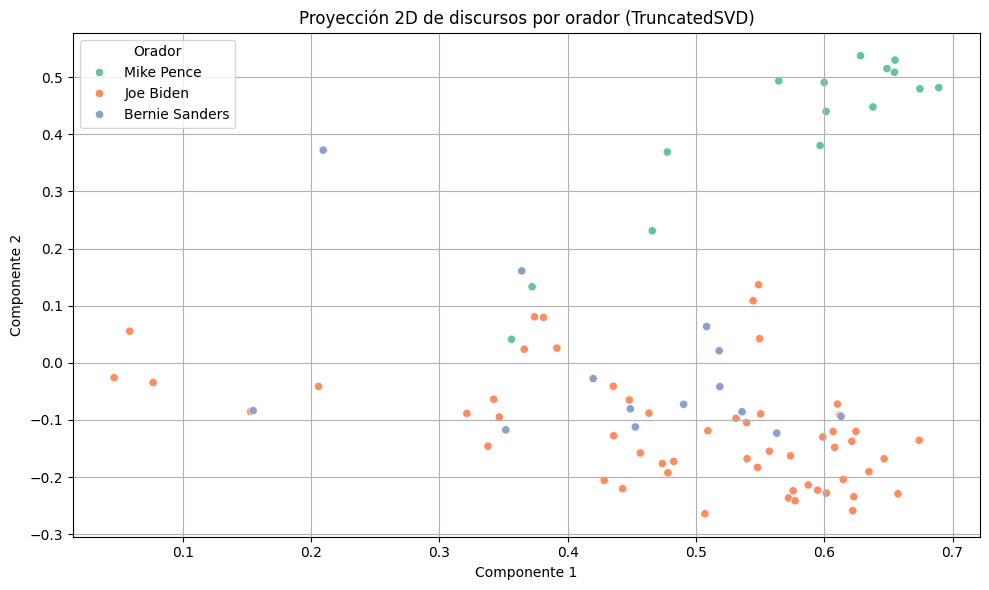

In [122]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

# 1. Extraer texto y etiquetas
X_train_text = train_df_selected['CleanText']
y_train_labels = train_df_selected['paragraph_speaker']

# 2. Vectorizar con TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 1))
X_train_tfidf = vectorizer.fit_transform(X_train_text)

# 3. Aplicar TruncatedSVD para reducción a 2D
svd = TruncatedSVD(n_components=2, random_state=42)
X_train_2D = svd.fit_transform(X_train_tfidf)

# 4. Preparar DataFrame para visualización
plot_df = pd.DataFrame(X_train_2D, columns=['Component 1', 'Component 2'])
plot_df['Orador'] = y_train_labels.values

# 5. Gráfico de dispersión
plt.figure(figsize=(10, 6))
sns.scatterplot(data=plot_df, x='Component 1', y='Component 2', hue='Orador', palette='Set2')
plt.title("Proyección 2D de discursos por orador (TruncatedSVD)")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.legend(title='Orador')
plt.grid(True)
plt.tight_layout()
plt.show()



###### Discusión punto 5

Para evaluar el impacto del desbalance de clases, se redefinió el conjunto de oradores seleccionados, utilizando a Joe Biden, Mike Pence y Bernie Sanders. Esta elección introdujo un escenario con una clase dominante (Joe Biden, ≈65%) y dos clases minoritarias (Pence y Sanders, ambas ≈17-18%).

Se realizó una partición estratificada en entrenamiento y test, y se visualizaron las proporciones relativas en ambos conjuntos. El gráfico evidencia claramente la presencia de un desbalance moderado, con Joe Biden ampliamente representado. Esta diferencia en la cantidad de ejemplos puede sesgar el modelo durante el aprendizaje, favoreciendo la clase dominante.

Para explorar cómo se distribuyen las clases en el espacio de representación, se aplicó reducción de dimensión con TruncatedSVD (PCA) sobre los vectores TF-IDF del conjunto de entrenamiento. El gráfico de dispersión mostró que Mike Pence aparece relativamente bien separado, lo que sugiere que el modelo podría distinguirlo con facilidad si tiene suficiente representación. En cambio, los discursos de Bernie Sanders se encuentran parcialmente solapados con los de Joe Biden, lo que podría dificultar su clasificación correcta.

Frente a este escenario, una posible solución sería aplicar técnicas de balanceo de clases sobre el conjunto de entrenamiento:

Sobremuestreo (oversampling): generar ejemplos adicionales de las clases minoritarias (duplicación aleatoria o técnicas sintéticas como SMOTE).

Submuestreo (undersampling): reducir la cantidad de ejemplos de la clase mayoritaria para igualar su representación.

Estas técnicas se aplican exclusivamente sobre el conjunto de entrenamiento, ya que el conjunto de test debe reflejar la distribución natural del problema. Aunque sería posible balancear también el test por motivos comparativos, eso comprometería su rol como herramienta de evaluación objetiva y realista del desempeño del modelo. Por tanto, mantener el test con su distribución original permite una medición más fiel de cómo funcionaría el modelo en condiciones reales.

#####6

Técnica alternativa para extraer features de texto: Word Embeddings.

Una técnica alternativa muy utilizada en el procesamiento de texto es el uso de word embeddings, tales como Word2Vec, GloVe o FastText.

A diferencia de bag-of-words o TF-IDF, que representan las palabras como vectores dispersos (sparse) y de alta dimensionalidad donde cada dimensión representa una palabra del vocabulario, los embeddings representan cada palabra mediante un vector denso de baja dimensión, que es aprendido a partir de un gran corpus de texto.

¿Cómo funciona Word2Vec?
Word2Vec (https://www.tensorflow.org/text/tutorials/word2vec) es una técnica basada en redes neuronales que aprende a representar palabras de forma tal que las que aparecen en contextos similares tengan representaciones similares. Existen dos variantes principales:

CBOW (Continuous Bag of Words): predice una palabra a partir de su contexto.

Skip-gram: predice el contexto a partir de una palabra.

Por ejemplo, las palabras rey y reina terminan teniendo vectores similares, y además se pueden capturar relaciones semánticas como:


vector("rey") - vector("hombre") + vector("mujer") ≈ vector("reina")

Diferencias esperadas en los resultados:

- Ventaja semántica: mientras que bag-of-words y TF-IDF solo capturan la frecuencia de aparición de palabras (sin contexto), los embeddings permiten capturar relaciones semánticas y de contexto.

- Reducción de dimensionalidad: los vectores de embeddings suelen tener entre 50 y 300 dimensiones, mucho menos que las miles de dimensiones de un modelo de bolsa de palabras.

- Generalización: los modelos con embeddings suelen generalizar mejor cuando se enfrentan a palabras similares no vistas durante el entrenamiento.

- Reducción de ruido: palabras poco frecuentes, errores tipográficos o expresiones raras afectan menos porque no se dependen tanto de la frecuencia exacta.

- Limitación: requieren un entrenamiento más costoso, o bien la utilización de modelos preentrenados. Además, pueden perder interpretabilidad respecto a modelos basados en frecuencia o generar sobreajuste si el dataset es chico.

En definitiva, estas técnicas utilizan herramientas que en teoría predicen mejor la mayor cantidad de las veces, especialmente cuando el vocabulario es rico, los textos son largos o variados, y hay ambigüedad semántica. Pero cuando de por sí los modelos basados en frecuencia ajustan bien, las limitaciones de estas técnicas alternativas podrían ser suficientes como para no tener que elegirlas.

#####Opcional

In [123]:
# OPCIONAL: Repetir la clasificación con los tres candidatos con más discursos, pero esta vez clasificando a nivel de párrafos y no de discursos enteros.

#Limpieza
df_paragraphs_clean = df_paragraphs.copy()
df_paragraphs_clean["CleanParagraph"] = clean_text(df_paragraphs_clean, "paragraph")

#Filtro de los tres candidatos con más párrafos
top_3_p_candidates = df_paragraphs_clean['paragraph_speaker'].value_counts().head(3).index
df_p_top_3 = df_paragraphs_clean[df_paragraphs_clean['paragraph_speaker'].isin(top_3_p_candidates)]
df_p_top_3['paragraph_speaker'].value_counts()


# Partición estratificada por el orador
train_p_df, test_p_df = train_test_split(
    df_p_top_3,
    test_size=0.3,
    stratify=df_p_top_3['paragraph_speaker'],
    random_state=42
)

# X_dev, X_test, y_dev, y_test = ...
X_dev_p = train_p_df['CleanParagraph']
y_dev_p = train_p_df['paragraph_speaker']
X_test_p = test_p_df['CleanParagraph']
y_test_p = test_p_df['paragraph_speaker']

print(f"Tamaños de los conjuntos: {X_dev_p.shape} {X_test_p.shape}")
print(f"Tamaños de los conjuntos: {y_dev_p.shape} {y_test_p.shape}")
print("Train:")
print(train_p_df['paragraph_speaker'].value_counts(normalize=True))
print("\nTest:")
print(test_p_df['paragraph_speaker'].value_counts(normalize=True))

df_p_top_3['paragraph_speaker'].value_counts()


Tamaños de los conjuntos: (5745,) (2463,)
Tamaños de los conjuntos: (5745,) (2463,)
Train:
paragraph_speaker
Donald Trump    0.468930
Joe Biden       0.417058
Mike Pence      0.114012
Name: proportion, dtype: float64

Test:
paragraph_speaker
Donald Trump    0.468940
Joe Biden       0.416971
Mike Pence      0.114089
Name: proportion, dtype: float64


,count
paragraph_speaker,
Donald Trump,3849
Joe Biden,3423
Mike Pence,936


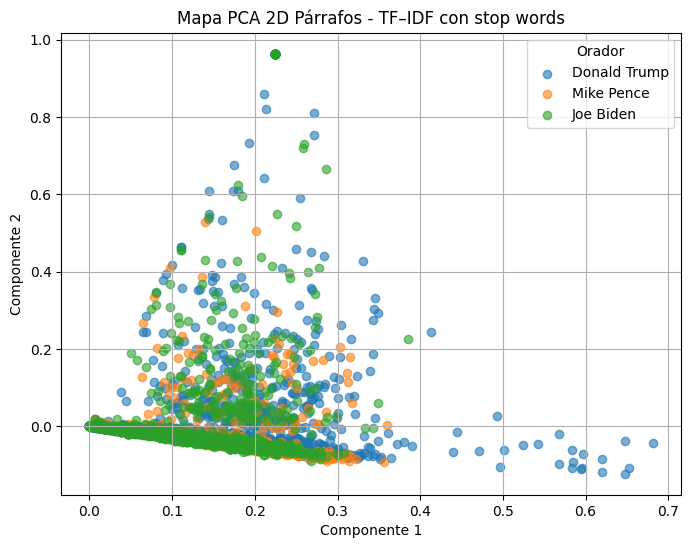

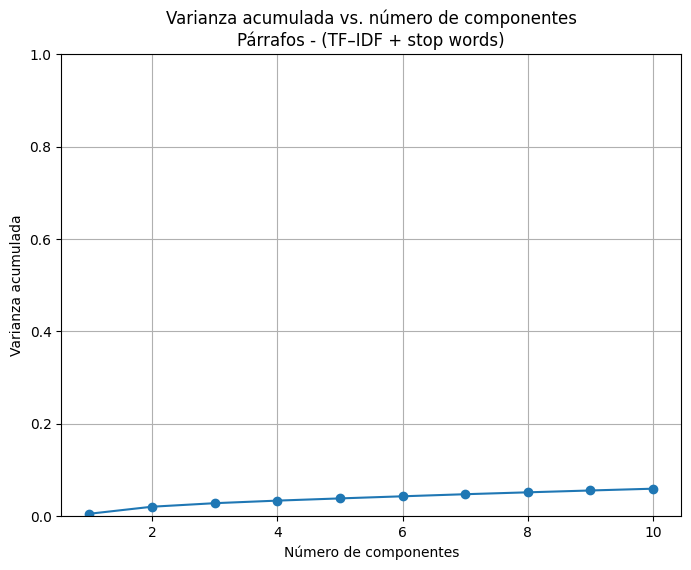

In [124]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

#Features y representación numérica
vectorizer_p = CountVectorizer(stop_words='english')
X_counts_p= vectorizer_p.fit_transform(X_dev_p)
tfidf_p = TfidfTransformer()
X_tfidf_p = tfidf_p.fit_transform(X_counts_p)

#PCA
pca_p = TruncatedSVD(n_components=2, random_state=42)
X_pca_p = pca_p.fit_transform(X_tfidf_p)
plt.figure(figsize=(8,6))
for speaker in y_dev_p.unique():
    mask = (y_dev_p == speaker)
    plt.scatter(
        X_pca_p[mask, 0],
        X_pca_p[mask, 1],
        label=speaker,
        alpha=0.6
    )
plt.title('Mapa PCA 2D Párrafos - TF–IDF con stop words')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.legend(title='Orador')
plt.grid(True)
plt.show()

#Curva de varianza explicada
pca_p_explained = TruncatedSVD(n_components=10, random_state=42)
pca_p_explained.fit(X_tfidf_p)
cum_p_variance = pca_p_explained.explained_variance_ratio_.cumsum()
plt.figure(figsize=(8,6))
plt.plot(range(1, 11), cum_p_variance, marker='o')
plt.title('Varianza acumulada vs. número de componentes\nPárrafos - (TF–IDF + stop words)')
plt.xlabel('Número de componentes')
plt.ylabel('Varianza acumulada')
plt.ylim(0,1)
plt.grid(True)
plt.show()



Fitting 5 folds for each of 16 candidates, totalling 80 fits
0.9234116623150566
{'clf__alpha': 0.01, 'clf__fit_prior': False, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 2)}


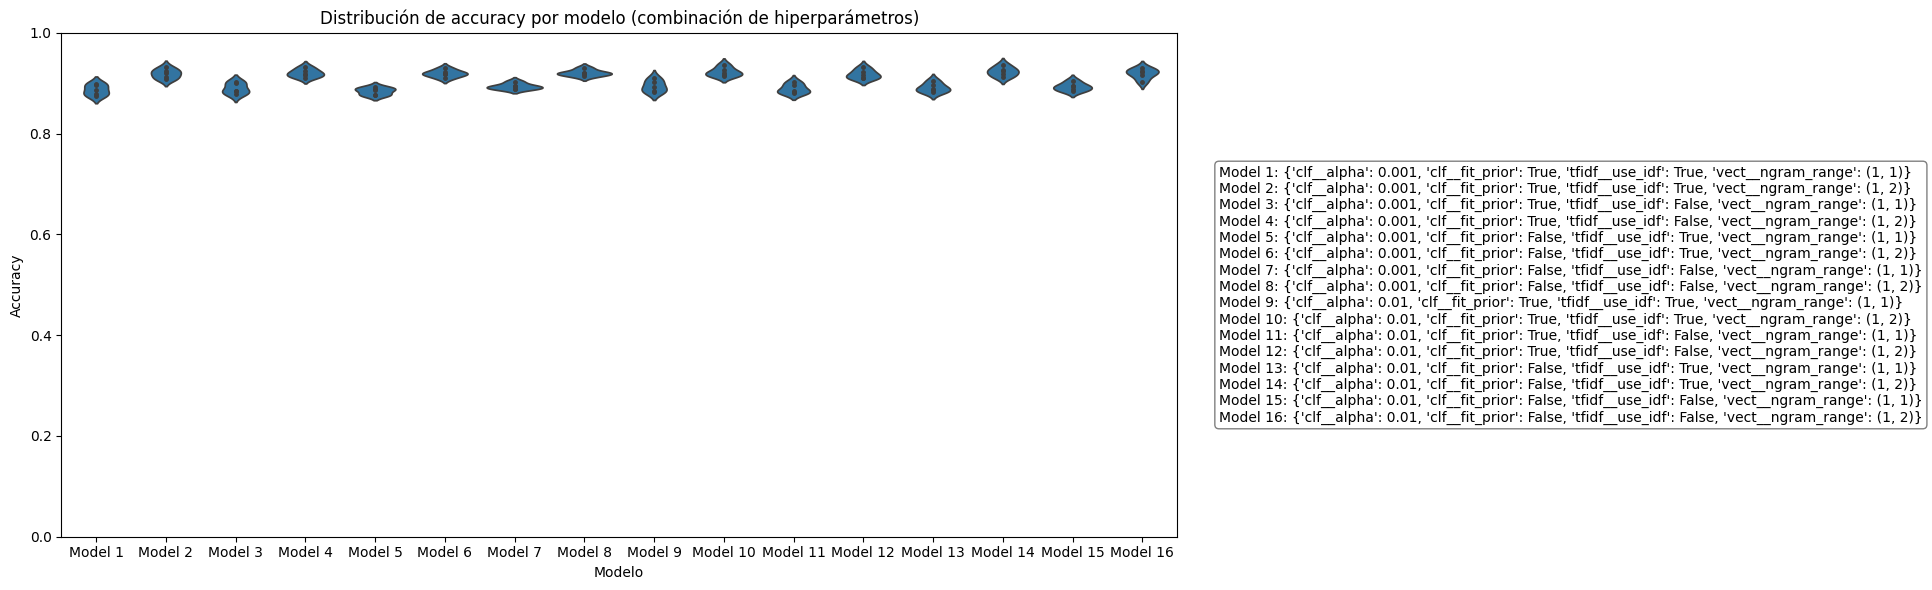

In [125]:

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Definir pipeline
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB())
])

# Definir grid de parámetros a probar
param_grid = {
    'vect__ngram_range': [(1,1), (1,2)],       # Unigramas o unigramas + bigramas
    'tfidf__use_idf': [True, False],            # Usar o no IDF
    'clf__alpha': [0.001, 0.01],
        'clf__fit_prior': [True, False] # Parámetro de suavizado del NB
}

# Instanciar GridSearchCV con validación cruzada 5 folds
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

# Ajustar a datos de entrenamiento
grid_search.fit(X_dev_p, y_dev_p)

print(grid_search.best_score_)       # Mejor accuracy promedio en los 5 folds
print(grid_search.best_params_)     # Hiperparámetros que lograron ese score
pd.DataFrame(grid_search.cv_results_)        # Todos los resultados detallados


# Genere una visualización que permita comparar las métricas (e.g: accuracy) de los distintos modelos entrenados, viendo el valor promedio y variabilidad de las mismas en todos los splits (e.g: en un gráfico de violín).

# Extraer resultados
results = []
labels = []

for i, params in enumerate(grid_search.cv_results_['params']):
    label = f'Model {i+1}'
    labels.append((label, params))  # guardamos el label y los params
    for fold_idx in range(5):
        score = grid_search.cv_results_[f'split{fold_idx}_test_score'][i]
        results.append({
            'model': label,
            'accuracy': score
        })

# Convertir a DataFrame
df_results = pd.DataFrame(results)

# Gráfico
plt.figure(figsize=(12, 6))
sns.violinplot(x='model', y='accuracy', data=df_results, inner='point')
plt.ylim(0, 1)
plt.title('Distribución de accuracy por modelo (combinación de hiperparámetros)')
plt.xlabel('Modelo')
plt.ylabel('Accuracy')
plt.xticks(rotation=0)

# Crear la leyenda como un cuadro al costado
legend_text = "\n".join([f"{label}: {params}" for label, params in labels])
plt.gcf().text(1.02, 0.5, legend_text, fontsize=10, va='center', bbox=dict(boxstyle="round", facecolor='white', edgecolor='gray'))

plt.tight_layout()
plt.show()

Fitting 5 folds for each of 16 candidates, totalling 80 fits
0.9185809264075783
{'clf__alpha': 0.01, 'clf__fit_prior': True, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 2)}


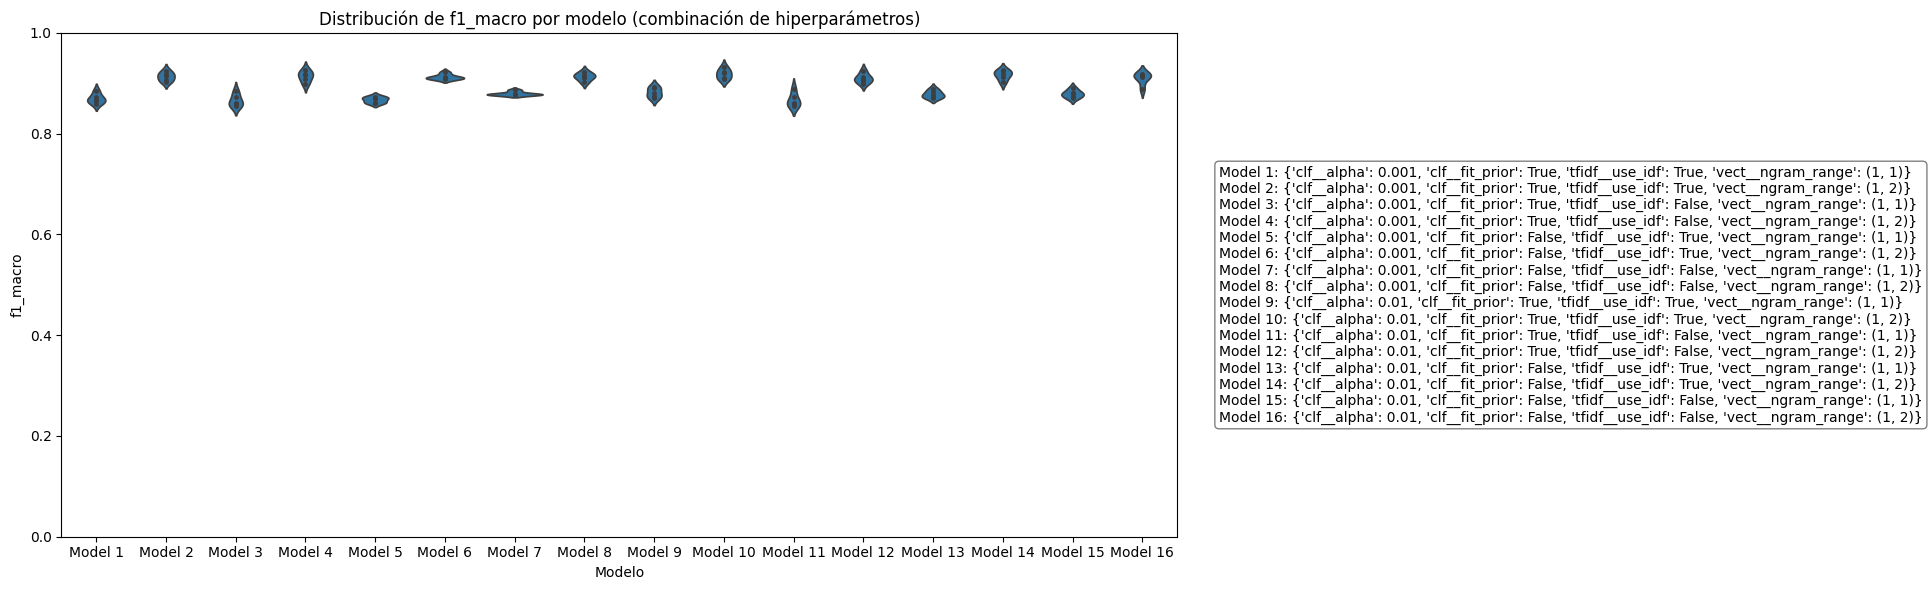

In [126]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Definir pipeline
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB())
])

# Definir grid de parámetros a probar
param_grid = {
    'vect__ngram_range': [(1,1), (1,2)],       # Unigramas o unigramas + bigramas
    'tfidf__use_idf': [True, False],            # Usar o no IDF
    'clf__alpha': [0.001, 0.01],
        'clf__fit_prior': [True, False] # Parámetro de suavizado del NB
}

# Instanciar GridSearchCV con validación cruzada 5 folds
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_macro', n_jobs=-1, verbose=1)

# Ajustar a datos de entrenamiento
grid_search.fit(X_dev_p, y_dev_p)

print(grid_search.best_score_)       # Mejor accuracy promedio en los 5 folds
print(grid_search.best_params_)     # Hiperparámetros que lograron ese score
pd.DataFrame(grid_search.cv_results_)        # Todos los resultados detallados


# Genere una visualización que permita comparar las métricas (e.g: accuracy) de los distintos modelos entrenados, viendo el valor promedio y variabilidad de las mismas en todos los splits (e.g: en un gráfico de violín).

# Extraer resultados
results = []
labels = []

for i, params in enumerate(grid_search.cv_results_['params']):
    label = f'Model {i+1}'
    labels.append((label, params))  # guardamos el label y los params
    for fold_idx in range(5):
        score = grid_search.cv_results_[f'split{fold_idx}_test_score'][i]
        results.append({
            'model': label,
            'f1_macro': score
        })

# Convertir a DataFrame
df_results = pd.DataFrame(results)

# Gráfico
plt.figure(figsize=(12, 6))
sns.violinplot(x='model', y='f1_macro', data=df_results, inner='point')
plt.ylim(0, 1)
plt.title('Distribución de f1_macro por modelo (combinación de hiperparámetros)')
plt.xlabel('Modelo')
plt.ylabel('f1_macro')
plt.xticks(rotation=0)

# Crear la leyenda como un cuadro al costado
legend_text = "\n".join([f"{label}: {params}" for label, params in labels])
plt.gcf().text(1.02, 0.5, legend_text, fontsize=10, va='center', bbox=dict(boxstyle="round", facecolor='white', edgecolor='gray'))

plt.tight_layout()
plt.show()


=== Modelo elegido por discursos ===
Accuracy: 0.8969


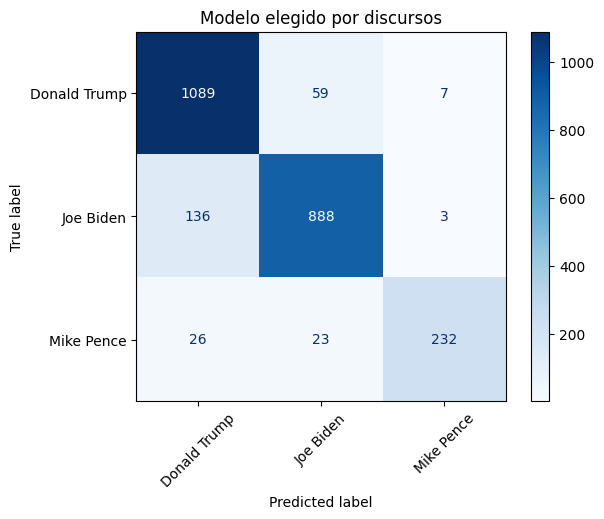

              precision    recall  f1-score   support

Donald Trump       0.87      0.94      0.91      1155
   Joe Biden       0.92      0.86      0.89      1027
  Mike Pence       0.96      0.83      0.89       281

    accuracy                           0.90      2463
   macro avg       0.91      0.88      0.89      2463
weighted avg       0.90      0.90      0.90      2463


=== Modelo elegido por accuracy ===
Accuracy: 0.9310


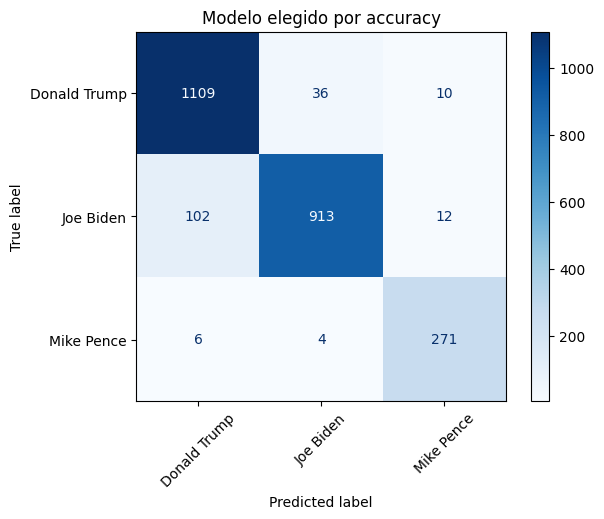

              precision    recall  f1-score   support

Donald Trump       0.91      0.96      0.94      1155
   Joe Biden       0.96      0.89      0.92      1027
  Mike Pence       0.92      0.96      0.94       281

    accuracy                           0.93      2463
   macro avg       0.93      0.94      0.93      2463
weighted avg       0.93      0.93      0.93      2463


=== Modelo elegido por f1 ===
Accuracy: 0.9306


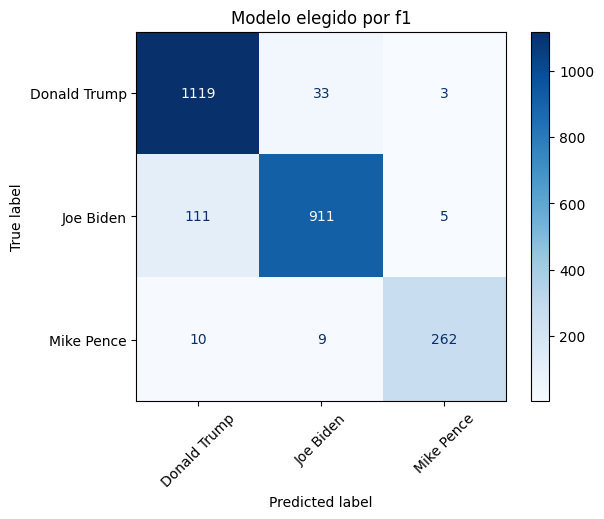

              precision    recall  f1-score   support

Donald Trump       0.90      0.97      0.93      1155
   Joe Biden       0.96      0.89      0.92      1027
  Mike Pence       0.97      0.93      0.95       281

    accuracy                           0.93      2463
   macro avg       0.94      0.93      0.94      2463
weighted avg       0.93      0.93      0.93      2463



In [127]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# --- Datos de entrada: X_dev_p, y_dev_p, X_test_p, y_test_p (textos planos y labels) ---

modelos = {
    "Modelo elegido por discursos": {
        'vect__ngram_range': (1, 1),
        'vect__use_idf': True,
        'clf__alpha': 0.001,
        'clf__fit_prior': True
    },
    "Modelo elegido por accuracy": {
        'vect__ngram_range': (1, 2),
        'vect__use_idf': True,
        'clf__alpha': 0.01,
        'clf__fit_prior': False
    },
    "Modelo elegido por f1": {
        'vect__ngram_range': (1, 2),
        'vect__use_idf': True,
        'clf__alpha': 0.01,
        'clf__fit_prior': True
    }
}

for nombre, params in modelos.items():
    print(f"\n=== {nombre} ===")

    # Crear pipeline
    pipe = Pipeline([
        ('vect', TfidfVectorizer()),
        ('clf', MultinomialNB())
    ])

    # Setear hiperparámetros
    pipe.set_params(**params)

    # Entrenar con texto plano
    pipe.fit(X_dev_p, y_dev_p)

    # Predecir y evaluar
    y_pred = pipe.predict(X_test_p)

    print(f"Accuracy: {accuracy_score(y_test_p, y_pred):.4f}")
    ConfusionMatrixDisplay.from_predictions(y_test_p, y_pred,cmap="Blues", xticks_rotation=45)
    plt.title(nombre)
    plt.show()
    print(classification_report(y_test_p, y_pred))

